In [1]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial

from torch.optim.lr_scheduler import StepLR

from model import NN
from functions import gaussian_loss_function
from train import training_routine, testing_routine
from visuals import plot_transformed_grid_and_density, compute_gaussian_density, compute_uniform_circle_density

from matplotlib import pyplot as plt

In [7]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [2]:
angles = np.linspace(0, 2*np.pi, 200)
circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
amplitude = np.sin(5*angles)+2
star = circle*amplitude.reshape(-1,1)

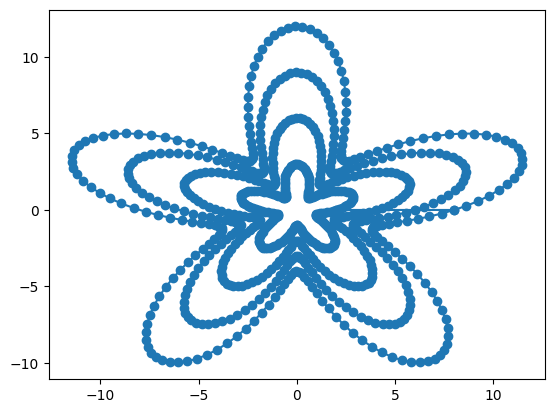

In [4]:
star_grid = np.repeat(star.reshape(-1,2,1), 4, axis=2)
star_grid = star_grid*np.arange(1,5)
star_grid= np.concatenate(np.split(star_grid, 4, axis=2)).reshape(-1,2)
plt.plot(star_grid[:,0], star_grid[:,1], '-o')
star_grid = torch.tensor(star_grid, device=device, dtype=torch.float32)

NameError: name 'device' is not defined

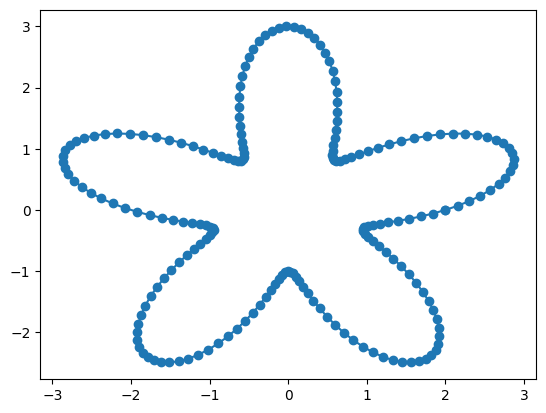

In [3]:
plt.plot(star[:,0], star[:,1], '-o')

#plt.plot(star[:,0], star[:,1], '-o')
star = torch.tensor(star, device=device, dtype=torch.float32)
#star = torch.tensor(star, device=device)
#star = torch.concatenate((torch.tensor([[0.,0.]], device=device, requires_grad = False), star))
#compute_volume(torch.tensor(circle))
target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


In [4]:
# Isoperimetrisches Problem

''' Objective Function '''

def isoperimetric_loss(points, a):
    
    
    diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    diff = torch.diff(points, axis=0)
    distances = torch.sum(diff**2, axis=1)

    #print(distances)
    
    coordinates = points - torch.mean(points, axis=0)
    angles = torch.atan2(coordinates[:,1], coordinates[:,0])
    angle_diffs = torch.arcsin(torch.sin(torch.diff(torch.concatenate((angles, angles[:1]))))) - 2*torch.pi/points.shape[0]

    #print(angle_diffs)
    
    angle_loss = a*torch.sum(angle_diffs**2)
    distance_loss = torch.sum(distances)
    
    print(f'angle_loss: {angle_loss}, distance_loss: {distance_loss}' )
    
    return  angle_loss + distance_loss, angle_loss, distance_loss

def orthogonal_projection(v, grad):
    return grad - grad@v * v / torch.norm(v)**2


In [5]:
# functions to access gradient

def get_grad_vector(model):
    shapes = get_shapes(model)
    
    weights = []
    
    counter = 0
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
    
            grad = linear_layer.weight.grad
            if grad is None:
                weights.append(torch.zeros(shapes[counter], device=device))
            else:
                weights.append(grad)
    
            counter += 1
    
        for linear_layer in coupling_layer.s_net:
            grad = linear_layer.weight.grad
            if grad is None:
                weights.append(torch.zeros(shapes[counter], device=device))
            else:
                weights.append(grad)
    
            counter += 1
    vector = torch.concatenate([w.flatten() for w in weights])
    return vector

def get_shapes(model):
    shapes = []
    
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
            shapes.append(linear_layer.weight.shape)
            #shapes.append(linear_layer.bias.shape)
        for linear_layer in coupling_layer.s_net:
            shapes.append(linear_layer.weight.shape)
            #shapes.append(linear_layer.bias.shape)

    return shapes 

def get_weights_from_vector(vector, shapes):
    lengths = [np.prod(s) for s in shapes]
    return [t.reshape(shapes[i]) for i,t in  enumerate(torch.split(vector, lengths))]

def assign_grad_weights(model, grad_weights):
    counter = 0
    
    for coupling_layer in model.layers:
        for linear_layer in coupling_layer.t_net:
            linear_layer.weight.grad = grad_weights[counter]
            counter += 1
            #linear_layer.bias.grad = grad_weights[counter]
            #counter += 1
        for linear_layer in coupling_layer.s_net:
            linear_layer.weight.grad = grad_weights[counter]
            counter += 1
            #linear_layer.bias.grad = grad_weights[counter]
            #counter += 1

In [8]:
# functions for volume computation

def compute_area_triangle(points):
    diff = torch.diff(torch.concatenate((points, points[:1])), axis=0)
    distances = torch.sum(diff**2, axis=1)**0.5
    s = torch.sum(distances) / 2
    return (s*torch.prod(s - distances))**0.5
    
points = torch.tensor([[1,2], [3,4], [5,100]])
print(compute_area_triangle(points))

def compute_volume(points, origin=torch.tensor([0,0], device=device, requires_grad=False)):
    sum_vol = 0
    for i in range(points.shape[0]-1):
        #print(compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2)))
        sum_vol += compute_area_triangle(torch.concatenate([origin, points[i], points[i+1]]).reshape(3,2))
    sum_vol +=compute_area_triangle(torch.concatenate([origin, points[-1], points[0]]).reshape(3,2))
    return sum_vol


def compute_area(points, origin=torch.tensor([0.,0.], device=device, requires_grad=False)):
    repeated = origin.repeat(points.shape[0], 1)
    stacked_points = torch.stack((repeated, points, torch.roll(points, -1, 0), repeated))
    t=torch.diff(stacked_points, axis=0)
    length=torch.sum(t**2, axis=2)**0.5
    s = torch.sum(length, axis=0)/2
    area_triangles=torch.prod(s-length,axis=0)**0.5 *s**0.5#, s, length, s-length
    area=torch.sum(area_triangles)
    return area


def compute_area2(points, device=device, requires_grad=False):
    coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    #print(norms)
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', normalized[::2],normalized[1::2]))).reshape(-1,1) * norms[::2] * norms[1::2])


tensor(93.9996)


In [36]:
# training routine

def training_routine_isoperimetric(model, outer_points, inner_points, optimizer, a=0, method = 0):
    torch.autograd.set_detect_anomaly(True)
    model.train()
    #train_loss = 0

    if method == 0:
        
        """outputs of individual affine coupling layers are needed for the loss function"""
        layers = []
        for j in range(len(model.layers)):
            layers.append("layers.{}".format(j))

        saved_layers, handles = register_activation_hooks(model, layers_to_save=layers)
        
        # get volume grad
        optimizer.zero_grad(set_to_none=True)
        output1 = model(inner_points)
        volume = compute_exact_volume_change(saved_layers)
        volume.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
        volume_grad = get_grad_vector(model)
        #print(volume, volume_grad[:10])
        print('volume', volume)
        output1.detach()
        volume.detach()
        


        # get loss grad
        optimizer.zero_grad(set_to_none=True)
        output2 = model(outer_points)
        isoperi_loss, al, dl = isoperimetric_loss(output2, a)
        loss = isoperi_loss
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
        
        # project on subspace
        grad = get_grad_vector(model)
        #print(grad[:10])
        grad_projected = orthogonal_projection(volume_grad, grad)
        #print(grad_projected[:10])
        shapes = get_shapes(model)
        grad_weigths = get_weights_from_vector(grad_projected, shapes)
        
        # assign values
        assign_grad_weights(model, grad_weigths)

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
        
        # train step
        optimizer.step()
        loss = loss.detach()
        print('loss', loss)
        volume = volume.detach()
        al = al.detach()
        dl = dl.detach()
        isoperi_loss.detach()
        output1.detach()
        output2.detach()
        remove_activation_hooks(handles)
        
        return  volume, al, dl#0,0#volume_grad, grad 
    
    else:

        """outputs of individual affine coupling layers are needed for the loss function"""
        layers = []
        for j in range(len(model.layers)):
            layers.append("layers.{}".format(j))

        saved_layers, handles = register_activation_hooks(model, layers_to_save=layers)
        
        # get loss grad
        optimizer.zero_grad(set_to_none=True)

        output = model(torch.concat((outer_points, inner_points)))
        volume = compute_exact_volume_change(saved_layers)
        print('volume', volume)
        volume_diff = (volume - 1)**2

        isoperi_loss, al, dl = isoperimetric_loss(output[:outer_points.shape[0]], a)
        loss = isoperi_loss + 0.1*volume_diff
        loss.backward()
    
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)

        # train step
        optimizer.step()
        loss = loss.detach()
        print('loss', loss)
        volume = volume.detach()
        al = al.detach()
        dl = dl.detach()
        isoperi_loss.detach()
        output.detach()
        remove_activation_hooks(handles)
        
        return  volume, al, dl#0,0#volume_grad, grad 

In [10]:
# functions for error search

def get_weights_vector(model):
    with torch.no_grad():
        weights = []
        
        for coupling_layer in model.layers:
            for linear_layer in coupling_layer.t_net:
                weights.append(linear_layer.weight)
                #weights.append(linear_layer.bias)
            for linear_layer in coupling_layer.s_net:
                weights.append(linear_layer.weight)
                #weights.append(linear_layer.bias)
    
        vector = torch.concatenate([w.flatten() for w in weights])
        return vector

In [11]:
def save_activations(activations_dict, name, module, input, output):
    activations_dict[name].append(output)

def register_activation_hooks(model, layers_to_save):
    """Register forward hooks in specified layers"""
    activations_dict = {name: [] for name in layers_to_save}
    handles = []
    for name, module in model.named_modules():
        if name in layers_to_save:
            handle = module.register_forward_hook(partial(save_activations, activations_dict, name))
            handles.append(handle)
    return activations_dict, handles

def remove_activation_hooks(handles):
    """Remove registered hooks"""
    for handle in handles:
        handle.remove()

def compute_exact_volume_change(layers):
    '''assuming volume of figure is 1'''
    temp = [torch.reshape(layers[f'layers.{i}'][0][1], (-1, 1)) for i in range(len(layers))]
    log_dets = torch.cat(temp, axis=1)
    return (torch.e**log_dets.sum(axis=1)).mean()

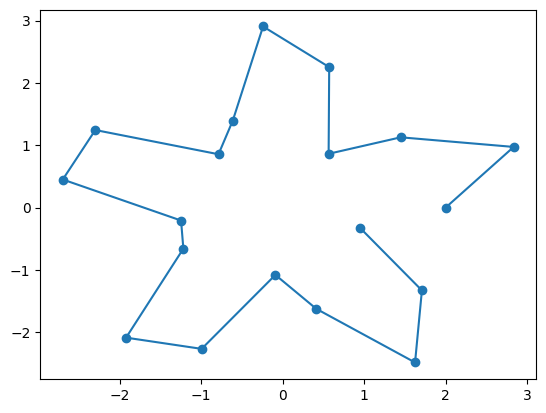

In [42]:
plt.plot(star[:,0], star[:,1], '-o')
star = torch.tensor(star, device=device, dtype=torch.float32)


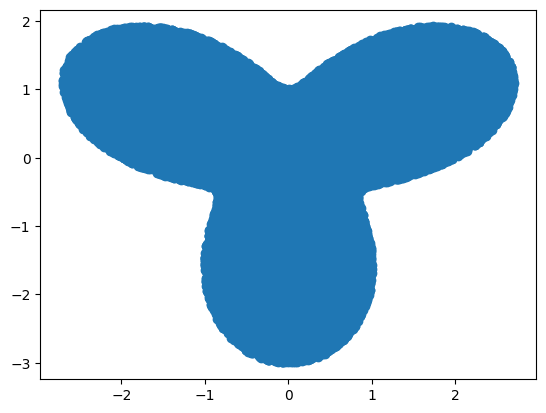

In [13]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

inner_points = generate_star(max_num=100000, n_edges=3, device=device)
plt.scatter(np.array(inner_points.cpu())[:,0], np.array(inner_points.cpu())[:,1])

C:\Users\Admin\AppData\Local\Temp\ipykernel_14196\1263116623.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


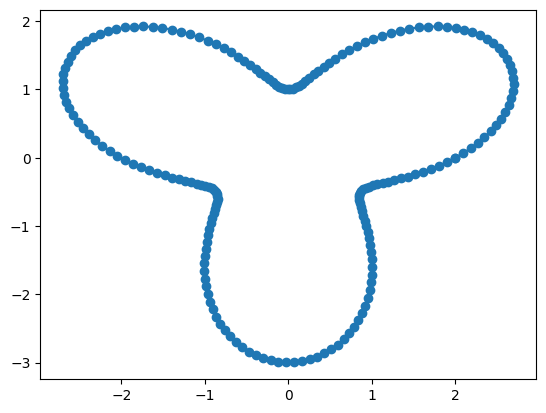

In [14]:
angles = np.linspace(0, 2*np.pi, 200)
circle = np.stack((np.cos(angles), np.sin(angles)), axis=1)
amplitude = np.sin(3*angles)+2
star = circle*amplitude.reshape(-1,1)

plt.plot(star[:,0], star[:,1], '-o')

#plt.plot(star[:,0], star[:,1], '-o')
star = torch.tensor(star, device=device, dtype=torch.float32)
#star = torch.tensor(star, device=device)
#star = torch.concatenate((torch.tensor([[0.,0.]], device=device, requires_grad = False), star))
#compute_volume(torch.tensor(circle))
target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


In [45]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [70]:
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [69]:
scheduler.get_last_lr()

[0.5471566423907612]

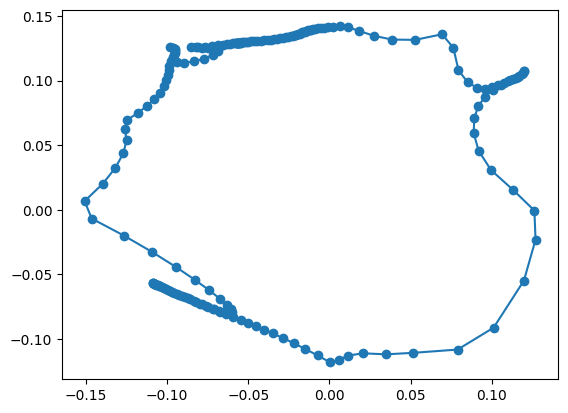

In [37]:
output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

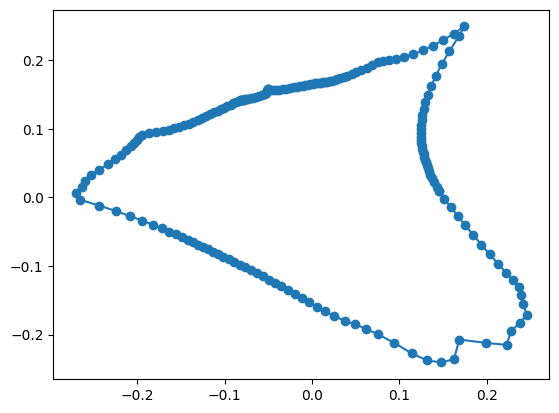

In [42]:
output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

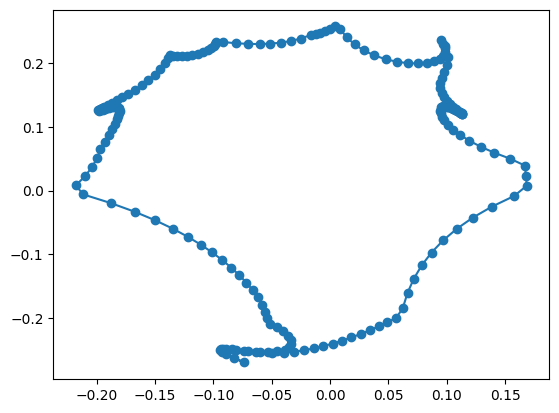

In [50]:
output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

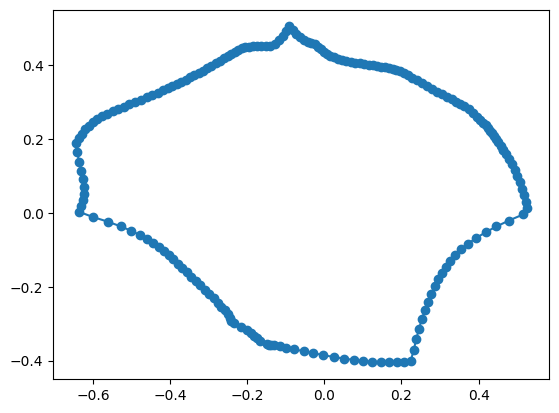

In [59]:
# add angle loss

output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

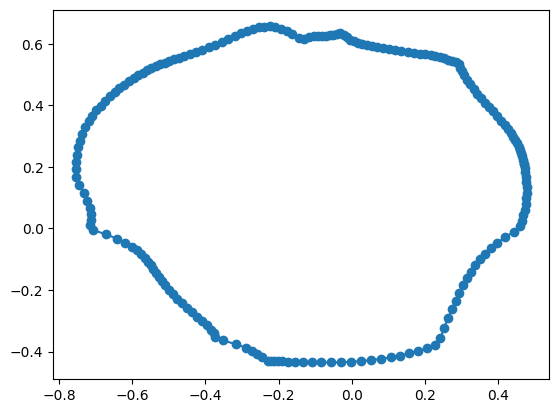

In [63]:
# now with vector projection, hold volume constant

output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

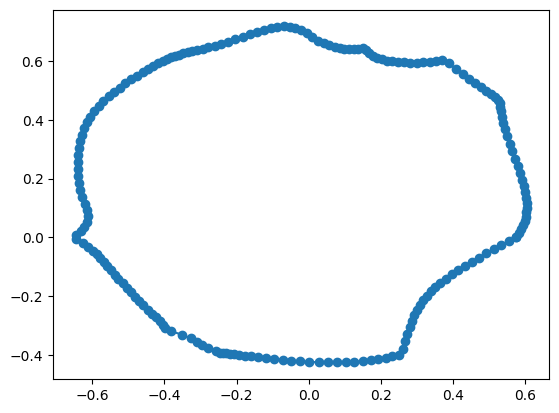

In [68]:
# lr 1, momentum 0.2

output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

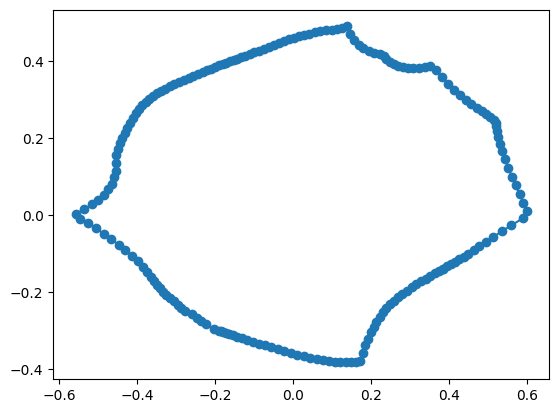

In [74]:
# lr 1, momentum 0.2, method 1, angle loss

output = model(star[::])
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [341]:
compute_volume(output)

tensor(12.0728, device='cuda:0', grad_fn=<AddBackward0>)

In [56]:
n=9
plt.plot(star[n::10,0].detach().cpu().numpy(), star[n::10,1].detach().cpu().numpy())
star[n::10,1].shape

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [80]:
np.random.randint(10)

6

In [73]:
%%time
weights = []
gradients = []
losses = []

method = 1
# n = np.random.randint(10)
# v, al, dl = training_routine_isoperimetric(model, star[n::10], optimizer, a=1, method = method)

for _ in range(300):
    # with torch.no_grad():
    #     new_method = 1 if (v-10)**2 > 1 else 0
    #     if (new_method - method)**2 > 0.5:
    #         lr = 0.1 if new_method == 0.1 else 10.
    #         optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
    #         scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
    #         method = new_method
    # print(method)

    # factors = [10]
    # m = factors[np.random.randint(len(factors))]
    # n = np.random.randint(200 / m)
    v, al, dl = training_routine_isoperimetric(model, outer_points=star, inner_points=inner_points, optimizer=optimizer, a=1, method = method)
    losses.append((v,al,dl))
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(0.0576, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.012895554304122925, distance_loss: 0.06426725536584854
loss tensor(0.1660, device='cuda:0')
volume tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.012171044945716858, distance_loss: 0.06228777766227722
loss tensor(0.1635, device='cuda:0')
volume tensor(0.0556, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.01610204577445984, distance_loss: 0.0617731437087059
loss tensor(0.1671, device='cuda:0')
volume tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.012870678678154945, distance_loss: 0.060847893357276917
loss tensor(0.1630, device='cuda:0')
volume tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.01609472930431366, distance_loss: 0.06157759949564934
loss tensor(0.1669, device='cuda:0')
volume tensor(0.0565, device='cuda:0', grad_fn=<MeanBackward0>)
angle_loss: 0.011724253185093403, distance_loss: 0.062337443232536316
loss tensor(0.1631

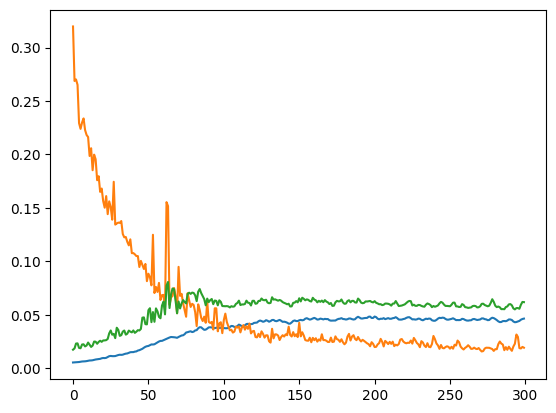

In [60]:
#losses = np.array(losses)
losses_cpu = [(l[0].cpu(), l[1].cpu(), l[2].cpu()) for l in losses]
plt.plot(losses_cpu)

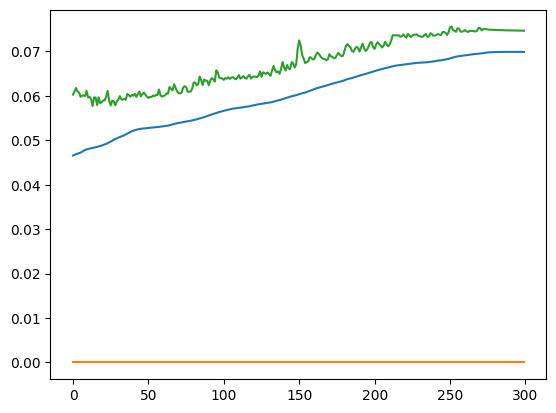

In [64]:
#losses = np.array(losses)
losses_cpu = [(l[0].cpu(), l[1].cpu(), l[2].cpu()) for l in losses]
plt.plot(losses_cpu)

In [147]:
shapes = get_shapes(model)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAiwAAAGdCAYAAAAxCSikAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAABiKElEQVR4nO3deXhU1eH/8fdM9n3fCYQlEPbIFoIoKpGguCAuiLbyRap1QVEsClSh1v5Ea1W00qKtVqsiiAutiCBEQJAIhn3fk0DIZCWZ7Nvc3x+RwSkBCQIZwuf1PPMkc++5d869TJjPnHvOuSbDMAxEREREnJi5pSsgIiIi8nMUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxeq4tXYFzwWazcfToUfz8/DCZTC1dHRERETkDhmFQVlZGdHQ0ZvPp21BaRWA5evQosbGxLV0NEREROQuHDx+mTZs2py3TKgKLn58f0HjA/v7+LVwbERERORNWq5XY2Fj75/jptIrAcvwykL+/vwKLiIjIReZMunOo062IiIg4PQUWERERcXoKLCIiIuL0FFhERETE6SmwiIiIiNNTYBERERGnp8AiIiIiTk+BRURERJyeAouIiIg4PQUWERERcXoKLCIiIuL0FFhERETE6SmwiIjIJW138W7+sfUfFFUVtXRV5DRaxd2aRUREzsafvv8T8/fMB2BX8S5eueqV8/6amaWZBHgEEOQZdN5fqzVRC4uIiFySsqxZzN8zHxMmAFZkr6CwqtC+PrM0kweWP8DMdTPZVbTrnLxmWnYaNy68kSvnX8nYr8ZSXF0MgGEY52T/rZlaWERE5JK0JmcNAAMiB1DVUMXWgq0s3L+Q3/T8DQB/3fRXvsv5ju/4jo/3fswnN35Cx8COZ/169bZ6Zm2YZX++MX8jf0z/I65mV9Ky0vB288bf3Z8QrxA6BXaiU2An2vi1wWxqbFtwMbng5+6Hn7sfvm6+eLh64OHigbvZHZPJdPYn4iKhwCIiIpek1UdWA3BFmysI8Ahga8FWPtr1Ee3829EztCffZH8DQHxQPPuO7WP25tn2S0a55bn8JeMvFFcX88dBfyTWPxbDMNhzbA8NtgZCvUIJ8QrB1XziY/bz/Z+Tac0kyCOIl4a8xG+X/Za07DT7emutFWutlSPlR9hSsKVZx+Lh0hhevFy9HB6uZldcza64mFxwNbviZnZr+qeLG66mxp9uZjeH9T8tMzxu+C897WfNZLSCdiir1UpAQAClpaX4+/u3dHVERMTJlNaU4u3qjZuLGwBV9VUM/mgwtbZa/nPzf4jyjeKGz28gvzIfAH93f6y1Vi4Lv4zpA6cz6r+jMDB4rM9jHC47zOJDi6mqrwIg0COQyf0n813Odyw+tNj+miZMBHkGEeUTRYhXCGty1mAzbDzZ/0l+3e3XvLHpDd7c+iZ+7n78ZchfiPSOxFprxVJpYf+x/ew7tg9LpcW+v3pbPeW15ZTVllFeV47Bhf34djO7sfHXG8/pPpvz+a0WFhERabU25G3g92t+T055Dv7u/jzR7wlu6XQLP1h+oNZWS7RPNO0D2mMymfjw+g+Zv2c+83fPx1prBWB0l9F0CurEiA4jWHRwEbM2zrLv+7Lwy6hrqGN70XZ+v+b3ALiaXAn2CqaoqogGo4Hi6mJ7PxWA69tfz+guowF4sPeDdArqRI+QHrTxa+NY8bjTH5dhGNTb6qlpqLE/quurqaqvorK+kur6aqobqqm31dsfdba6s/p5/Pfjl6ZaigKLiIicc+W15Xi5euFidvlF+7EZNmyGzX5pZW3OWuZsncPtnW/nhg43nLbvRl1DHU+veZqc8hyg8ZLLjLUzyLJmsaNoB9B4Oej4PiJ9IpnYZyJ3dL6DF9a/gA0b17a7FoAn+j2Bt6s3x2qOEegRyPC44fSL7EdtQy3v73yf+XvmU9NQw0tDXmJg1EBsho1j1ccorCoky5rF4bLD9I/sT6+wXvb6uZhdzvoSi8lkarx84+KGL75ntY+LjS4JiYjIL7IxbyPpuemM7TYWX3dfsqxZ3P7F7cT5x/G3lL8R6hVqL7u7eDdHyo5QXF3MloIt9AztyZ0Jd560T8MwWLh/IS9veJmOAR15J/UdDAxu+PwGewAZ0WEEz13+HG5mNwzDYO3Rtfxr+7+os9UxLG4YBZUFvL39bUK9Qllw4wIW7l/Iaxtfs7+Gh4sHn9/8ObF+sb/4HBiGQb1Rj5vZ7Rfv61KiS0IiIvKLFFcX88TKJ3Azu+Hn7sf2wu2EeofSIaADR8uPck3ba7i7693sLNrJb5f9luqGavYW7+XVq1/lo90fUVVfxa7iXYz9aixvp75NiGcIL294mQ93fejwOv898F/yKvO4t8e9+Ln7AY0f/v9v3f+zz4+yMX8jXx76EleTKznlOXi7elPbUMuXB7+ksq6SfhH9WHRwEbuKTww93ph/oq/Fw4kPE+oVym96/gZLhcW+3/E9x5+TsAI/tniYFFbOJ7WwiIjISd7b8R5/yfjLacvc0OEG1uWuo6CqwL7s3h73smDvAspqy/Bz96OstoxOgZ3wcvViW+E2AHqF9sLP3Y8QrxD+e+C/9m17hfViTMIYDpQc4J/b/okJE0lRSXyf+z0xvjG4md3ItGYyIXECXUO68tiKx6iz1dm3dze7MzphNJHekXyb8y2ZpZl0DurM69e8br+kVF1fzYS0CdQb9bx57Zt4uHicy9MmzdScz28FFhEROcn9X99Pem46qXGpdAnqQs+wnuSW55JbkUtZbRkf7PrAXrZDQAdGxY9yCDgxvjH8Y9g/uOere+yTsfm7+/P84OcZEjvEXu7TvZ8yZ+scLBUnRsMc92T/J7mt821c/9n19n34uvmy5NYlBHgE8H3u9/x7x7/xdPWke0h3RsWP0uyxFxldEhIRkbNWVV/FhrwNADzU+yE6BHY4qUz7gPasOLyCK9tcyQ0dbsDP3Q8TJv6S8RcMDG7vfDuxfrH8PeXvPLT8Idr6t+X5wc8T7RvtsJ9bO9/KrZ1vpbCqkLm75rImZw1uLm4MazeMX3X9FSaTiacHPs2cLXPoHtKdMQljCPAIAGBg1EAGRg08/ydEnIJaWERExMHqI6t5KO0hIn0i+frWr5s1i+p3Od/x3dHvmJA4AW83b6BxpE9LD4kV56QWFhFpVX6w/EBGXgb397z/Fw+TlZ+39uhaAC6PvrzZU75fHnM5l8dc7rBMYUXOBQUWEXF6z6Y/S5Y1iw4BHUiNS23p6rQaZbVlWGutxPjG2JfZDBsrDq8AOCl4iLQkxV4RcWpltWVkWbMASD+a3sK1cT7rctcxedVkbl54M0szlzqsyyzN5MHlD/LlwS9P2s4wDH677Lfc8PkNbM7fbF++IW8DOeU5+Lj5MDhm8PmuvsgZU2AREae2u3i3/fe1R9fSCrrdNUudrY4lmUsory0/aV1FXQWPfvMoSzKXcLD0IP/c9k/7unpbPVNWT2FNzhqmrZnGqsOrHLbdXLCZbYXbqLfV89IPL2EzbAAs3L8QgOFxw/Fy9Tp/BybSTAosIuLUfhpYcity7a0tF5OvM7/m9i9ut98duDn+sfUfTF41uck5UZZmLqWyvpIonyjMJjO7i3fbhwf/e+e/7dPP2wwbk7+dzK6iExOrfbznY/vvWwu38tWhr6ioq2BZ1jIARnYa2ey6ipxPCiwi4tR+GlgA0nMvrstCm/M3M2X1FHYX7+bJb5/kcNnhM9623lbPp3s/BeDrrK+pa6hzWP/5vs+Bxhv09Q7rDcCqw6uoaajhH1v/AcCM5BkMjBpIVX0VE9ImYKmwUFJdwteZXwOQ0jYFgOfXPc/Ta56mqr6KOP84+/5EnIUCi4g4tZ1FOwFIDEsELq5+LDUNNUxaOYk6Wx1uZjfK68p5fMXj5Ffmn1TWMAx2FO5wCCVrctaQX9VYtqy2jPWW9fZ1B0sOsrlgMy4mF27qeBND2jROxrbyyErWHFlDeV05kT6RjIofxStXvULHgI7kV+XzcNrD/L91/49aWy1dg7vy4pUv0iusF9ZaK8uzl2M2mXlqwFPNHh0kcr4psIiI06qur+ZQ6SEA7up6FwB7ive0ZJWa5fi09WFeYXxy4ycEegSy59geRi8azb5j+xzKvvjDi9z55Z2MWzqOY9XHAOytK8enjz9+uQbgo90fAXBFzBWEeYdxVexVAKzPXW+/V87wuOGYTWb83P2YnTKbYM9g9h7by5LMJbiYXHiy/5O4u7gz66pZhHuFAzB1wFR1thWndFaBZfbs2cTFxeHp6UlSUhLr168/bfkFCxaQkJCAp6cnPXv2ZPHixQ7rTSZTk4+XXnrpbKonIq3E/pL9NBgNBHsGkxyVDMDRiqNU1lW2cM3OzPHhwde0vYYOgR344PoP6BTYicKqQt7Y9Ia93Nqja+03BdxSsIVxS8aRW57L6pzGPi9P9HsCgLTsNOpsdRRWFfL5/sbLQb/q9iugcXr8+KB4am219stm17W/zv4aMb4xvHHNG/bw81ifx+gX2Q+AMO8wPr3pU+bdMK/JOyeLOINmB5b58+czadIkZsyYwcaNG+nduzepqank55/cxAmwdu1axowZw/jx49m0aRMjR45k5MiRbN++3V4mNzfX4fHOO+9gMpm49dZbz/7IROSid7x1pVNgJwI9Awn2DG5cbj3UktU6IzbDxsrDKwG4OvZqANr5t+OlKxu/iH175FsKqwqpqq9i+nfTARjWbhjBnsEcKD3A5G8n02A00Cu0F7d3vp1Qr1BKakr4ZO8nfLDzA2oaaugZ2pMBkQOAxi9+Lw952T5tfZx/HF2DuzrUqWdYTz68/kNeueoVxnYf67Au0DOQ7iHdz9fpEPnFmh1YXnnlFe677z7GjRtHt27dmDNnDt7e3rzzzjtNln/ttdcYPnw4kydPpmvXrjz33HP06dOHN9448e0iMjLS4fGf//yHq6++mg4dTr5/hYhcOoqqioDGFgBobEWAxv4bzm574XYKqwrxcfOhf2R/+/JOQZ3oFdqLeqOeLw58wUe7PyKvMo9on2ieu/w57kpovPS1pWALADd0vAFXsysP9HoAgL9u/Cvv7XwPgN/0/I1DX5P2Ae3529C/0Su0Fw9f9nCT/VC6BHfh2nbXqo+KXHSaNdNtbW0tGzZsYOrUqfZlZrOZlJQU0tOb7giXnp7OpEmTHJalpqaycOHCJsvn5eXx5Zdf8t57752yHjU1NdTU1NifW63WZhyFiFwsjt+hN9QzFICOgR3JyMvgYKnzB5bjl4MGxwzG3cXdYd0t8bewtXArc3fPtV/eeijxIbzdvLmt8228ufVN6mx1uJpcGR43HIBRnUfxwa4PyLRmAo2Xe473W/mpXmG9+HDEh+fvwKTFGYZBXYNBg82gwWj8aRgnntts/Pjzx3Wn2U+Ty09R3gR0CPM9F4dwVpoVWAoLC2loaCAiIsJheUREBLt3725yG4vF0mR5i+XkW4kDvPfee/j5+TFq1KhT1mPmzJk8++yzzam6iFyECqt/DCxejYGlfUB7AA6UHDi7/VUVkmHJ4Jq215wUIn6J0ppS+6WY41ZkNwaW45eDfmp43HD+uumv9jlTOgZ05IYONwAQ4hVCalwqiw4uYnDMYII8gwBwM7vxzMBn+P13v+fGDjcy4bIJukdPK1LXYCO3pJqs4gqyiio5XFxJVlEleWXVVNU2UPnjo6q2nqq6BmwtMH+iu6uZvX+67ucLnidOdy+hd955h7vvvhtPT89Tlpk6dapDq43VaiU2NvZCVE9ELqDjLSwhXiFAYwsLnOjb0hx1DXX8ZulvOFB6gMSwRF69+lV7EPol/vLDX/j3zn/zWN/HuLfHvQBkW7M5UHoAV5MrV7S54qRtfN19+WjER3yy9xM2F2zm0csedbip4xP9niDQI9B+eei4AVEDWHbbsv/dnVwEauobyLfWkF9WQ561ujGQFFeSXVRJdnElOSVVNJyDFGIygYvJhNlswsVkwsVs4nRX/061qqlLhu6uLRuQmxVYQkNDcXFxIS8vz2F5Xl4ekZGRTW4TGRl5xuVXr17Nnj17mD9//mnr4eHhgYeHR3OqLiIXoeN9WI4Hi+N9WLLLsqltqG1WK8m7O97lQGljy8zmgs38ZulvmH/jfPuomaakZafxr+3/YlrSNLqFdDtp/ZqcNfb+JLM2zKJzUGcGxwy2Xw7qG9kXf3f/Jvcd7RvNo30ebXJdqFcoTw146oyPTVpeTX0Dh4uryCqqILOo0v4zr7Sa/LJqjlXW/ew+3F3NtA32pl2wN21DvGkb7E1UgBe+Hq54ubvg7e6Cl1vjTw83F1zNJswmE2YzPwknrbdvUrMCi7u7O3379iUtLY2RI0cCYLPZSEtLY8KECU1uk5ycTFpaGo899ph92bJly0hOTj6p7Ntvv03fvn3p3VszLIrIT/qw/BhYwrzC8HPzo6yujExrJp2DOp/RfiwVFt7c+iYAExIn8NHujzhQeoA3t7x5ytAA8OaWN9lVvItJKyex4MYF+Ln72ddV1FXYR/eEe4eTX5nP71b9jr9e81fSstOApi8HycXJZjMoKK8hu7jxck3jzyr773ll1fzcba7cXcyE+3sQ7udBmyBv2v0YStoGe9MuxIdwPw/M5tYbOH6pZl8SmjRpEmPHjqVfv34MGDCAWbNmUVFRwbhx4wC45557iImJYebMmQBMnDiRIUOG8PLLLzNixAjmzZtHRkYGb731lsN+rVYrCxYs4OWXXz4HhyUiF7u6hjpKakqAE4HFZDLRJbgLGXkZrDy88owDy6KDi6hpqKF3WG/u73U/nQI78djKx3hn+ztc2eZKEsMTT9omryKPXcWN997JKc/hkW8e4eHEh+kX0Q+TycSHuz6koKqAWL9Y5t0wj8dXPM56y3ruXXqvfR8KLBen2nobm7KPseVICbtyy9iVa+VQYQU19bbTbufj7kJcqA9xIT60C2kMJFEBXkT4exLu50Ggt1urbgE535odWEaPHk1BQQHTp0/HYrGQmJjIkiVL7B1rs7OzMZtPXOcaNGgQc+fO5emnn2batGnEx8ezcOFCevTo4bDfefPmYRgGY8aM+YWHJCKtQVF14+UgV5OrQ4fWUfGjyMjLYP7u+YzrMQ43s5t93bHqY0xcMZEAjwDG9xhPYngihmHwxYEvALg1/lZMJhND2w3lurjr+CrzKx795lHev/592vm3c3j9b3O+BSDKJ4rCqkI25G3g3qX3cmv8rTza51He3fEuAA8nPoy/uz+zh87miVVP8O2Rb/Fz8+POhDuJ9o0+n6dIzqGsogqW7czj232F/HComKq6hpPKuJhNRAV42ltFYn98HH8epEByXpmMVnCvdqvVSkBAAKWlpfj7N329WEQuLjsKd3Dnl3cS7h1O2u1p9uW1DbUM+2QYRdVFvHjFi1zf4Xr7ure3vc2sjbPsz6cMmEKf8D7csegOPFw8WHHHCvtlncq6Su5dei87inYQ6hXKc5c/R1JUkj0APZL2CCuPrOSRyx5haNuhvL/zfT7b9xk/HSTaKbATn9z4ib3DrM2wcaDkAHEBcQ5BSpxPXYON7TmlLN+Vx7KdeezNK3dYH+rrTv+4YLpF+ZMQ5U/nCF+iA71wc9HIrHOpOZ/fTjdKSEQETu6/cpy7izuju4zmb1v+xrw98xwCy5eHvgSga3BXdhXv4oX1L9DWry0AV8Ve5dAHxdvNmzeGvsF9X9/H/pL9PLj8QUyYGBwzmHt73Mv3ud8DMKTNEDoGduQPg/7A1bFXM3X1VMrqyvBw8eB3/X7nMLrHbDITHxR/fk6InLWa+gb2WsrZfrSUbTml7MgpZZeljNqfXOJxMZsYEBfM0K7hDI4PpUuEn1pLnIwCi4g4pVMFFmi8LPT3LX9nU/4mjpYfJdo3mr3H9rLv2D7czG78Y9g/eHPrm7y/832yy7Lt2/yvUK9Q5o6YyysZr/Dpvk+ps9WxOme1/R4+HQM6OvSTGRI7hG/u+Iay2jICPQPViuJEbDaDI8eq2JtXxqHCCrJ/HDZ8+MdHfRNDhv08XbkyPoxru0VwVZcwAr3P3dw8cu4psIiIUzpdYInwiaBvRF8y8jJYmrmUlHYpzNkyB4Ar21xJgEcAk/tNpmdoT+pt9XQJ7nLKDrperl78fuDvmZo0lX3H9jFl9RT2l+zn8ujL+cOgP5z0LdvT1RNP11PPEyXnz/GROoeLKzl8rPLHYcSV7MsvY19eeZP9To4L8HKjZ0wAPWIC6BHjT4/oANoGe2tUzkVEgUVEzqudRTsZv3Q8D/Z+kHu639NkmYLKAqasnsLlMZfzf93/D7PJbO90G+IZ0uQ217W/joy8DN7d8S6vbXyNBqPxw+qWTrcAjSOKfnq34p9jNpnpEtyFj2/4mCxrFh0DO+qSwHlU12DDUlpNcUUt1uo6rFX1P/6sa+J5PccqajlSUuVwGed/ubua6RjmS8cwn58MGfb5cbSOp/49L3IKLCJyXn158EvK68r5eO/Hpwwsiw8tZr1lPest69lasJW/DPnLaVtYAFLapfD8uucpri4GYEDkAEZ3Gc2Q2CG/qL5uLm50Cur0i/Yhja0h+WU1P7aENLaGHDl2omXEYq0+q5ldzSaICvAiNtiL2KDGUTqdI3yJj/CjXbA3ruoU22opsIjIeXX8rsNZ1iwsFRYifU6e5fp4GWicXXZ51vKTZrn9X8GewVzb7lq+zvqax/s8ztjuY/UN+gIyDIPiiloOH/sxiBRX2cPJkWNV5Byrorbh9POWuLuaCfP1wM/TFX8vN/w93fC3/35imZ+nKwHebrQJ9CYq0FMjdS5RCiwi8oscnxmhqbBQ01DDzqKd9uff537PyE4jmbp6KpvyN/HB9R8Q4hnClvzGwNInvA8b8zfy4a4P2V3ceEPVNn5tTvnaL1zxAtOSptlvECjnXoPN4EBBObtyrezMtXIgv9weTiprT91nBBpH3kQHetIm0NuhRSQ22Is2Qd6E+WpmVzlzCiwictbSj6bz4PIHmdx/Mnd3vfuk9buKdlFnO3EPlXW567iqzVV8efBLDAw+3vMxo+JHkV+Vj4vJhSkDpnDHojvYXLAZgO4h3eka3PWUr+9idlFYOcdsNoO9+WWs3V/E2gNFrDtURFl1/SnLR/h7nAgiQY1BpM2P4SQqwFOXaOScUWARkbP2wa4PaDAaeG/He4xJGIPZ5PjhdPxST7BnMMXVxazLXcf3ud/bJ1/7dO+n9hlmOwd1pmtIV3qE9GB70XYAxvUYp8s851l9g43tR61kZBaz/lAxGVnHKK6odSjj4+5CQpQ/XaP86BLp3zjLa5AX0YFeeLq5nGLPIueWAouInJWS6hLW5qwFILcil835m+kT0cehzOb8zQDcmXAnb297m4KqAt7Z/o59fX5VPn/f8ncAeoX1AuCGjjewvWg7bXzbkNI25QIcyaWlwWaw86iVNfsL+f5gERmZxVT8z6UdLzcX+rcPZlDHEJI7hNA92l8tJdLiFFhE5Kwsy15GvXHiUsHiQ4sdAovNsLEpfxPQOILnaPlRFu5faL+hYK/QXmwt3EqWNQuA3mGNd2m/o/MdVNVXcUXMFQ6zyMrZyy6qZM3+Qr7bX8h3BwopqaxzWO/v6Ur/uGD6tw+mf1wQPWMCcXdVQBHnosAicp6kH01nedZyHu3zqMPN+1qLJYeWADAwaiDf537P0sylTO4/GQ8XDwB2Fe+iqLoIb1dveoX2IsY3hq8OfUVNQw3uZndev+Z1Xt3wKquOrMLN7MblMZcDjcOKf9PzNy12XK1BfYONHzKP8fVOC2m78skurnRY7+vhysAOwSR3DGVgh2ASIv1xUedXcXIKLCLnyYy1M8ityGVb4TY+vvHjlq7Oz/pgZ2N/lLHdx/5s2dKaUjLyMgB4ZuAzjFs6jvzKfF7d8CptfNtQVldGg63xMsOg6EG4ubgR6RPJr7r+ire3v03/yP6EeIXwp8F/Ou0oIzlzlbX1fLu3kK93Wvhmd75DK4qr2cRlbQMZ3CmMwfEh9GoTqKHBctFRYBE5T3IrcoHGloYlmUsYHje8hWt0aodKD/HiDy8CjTcJXJa1jNzyXO7rdR+RPpEcLT/KJ3s/4aaONxEXEMe63HXYDBsdAjrQ1r8t0wdOZ8I3E/hw14f2fbqbG+/LcmWbK+3LHk58mGjfaHtrCiio/BJF5TWk7crn650WVu8rpOYns8AGersxNCGCa7tFMDg+FF8P/XcvFze9g0XOg9KaUofnr298ndR2qU774fzVoa/sv8/dNZe5u+cC8MXBL7it820szVxKfmU+C/cv5P3r32ft0cbOtoOiBwGNNwW8o/MdfLz3Y9zMbtTZ6qi1NY40uaLNFfZ9u7m4cUeXOy7UYbU6hmGwP7+cFXvyWb4zn4ysYn46WWybIC+GdYtkWPcI+rULUkdZaVUUWETOg5zyHKDxxnoNtgYOlx3mQMmBCz7lu2EYHCk/QhvfNqcMS4ZhOASWeXvmAeBmdqOqvor3d75vX1dQVcADyx6gsq6xT8TxwAIwNWkqg6IH0TOsJ4+vfJytBVvpHtL9lDPVypk5VlFL+sEi1uwvZNWeAnJKqhzW94jx59qujSElIdLPaUOxyC+lwCJyHhwpOwI0zi3i7+7P6pzVrDyy8pwEFmutlYeWP0Rbv7Y8f8XzpyxX11DHU6ufYlnWMp4Z+MwpWzZ2Fu8k05qJCRMGBjaj8bLC0wOfJsgjiPl75mM2mZnYZyITvplApjUTaAw0/SL72ffjanZlaLuhAPzp8j8xc91MftXtV7/4eC9FhworWLrDwpLtFrYcKcH4SSuKu6uZ5A4hXN0ljGu7RxIT6NVyFRW5gBRYRJpgM2x8efBL+kf2b/LeNz/ncNlhoHFa+T7hfVids5oVh1eck9Evf934V7YUbGFLwRbGJIyhZ1hP3t3+Lh/t/ojf9f8d17a7Fpth48lvn2R59nIA3t/5Prd3vp2DpQf5wfIDNQ01tA9oT+egzry4vrHvSkq7FDbmbaSoughXkytD2w4lwCOAq9tebX/tOSlzuOere7DWWukT0Qcv16Y/LNsHtOetYW/94mO9VBiGwa7cMpbssLB0u4U9eWUO6ztH+HJ5p1AGdwplUMdQvNw13FsuPQosIk1Iy05j2pppdA/pzkcjPmp2M/uR8sYWlja+bbgq9iqe+/45thVs40DJAToGdmxym//s/w9LM5fyRL8nCPcOZ97ueXy671M6BXbipSEv4eXqxY7CHczfM9++zUe7P2K9ZT2zNs4C4KlvnyIgJYDssmyWZy/H3eyOi9mFTGsmD6Y9yHc53zX52n5ufjzQ+wH+tf1fLDq4iIHRA5scit0xsCN/S/kbr298XUOPfyGbzWDT4WMs2W5hyQ4Lh4tPXOpxNZtI7hhCavdIru0WQYS/ZwvWVMQ5KLCINGFj3kYAdhTtYEvBFhLDE09b/nDZYSaumEiPkB78fuDv7ZeE2vi1Idw7nF5hvdhasJVR/x3FgMgBXBV7FXd0voPXNr7GJ/s+sbfCAOw9thc3s5s99OSU5/DoN4/yu36/Y9LKSRgY9AztybbCbXxx8At7HdoHtOdQ6SF+u/y3uJndAHis72NkWbOYv2e+PawMjBqIv7s/e4/tJdOaiZ+bH29e+yadgzpzX8/7KKkp4ZHLHjnlsfYO683bqW+f3Ym9hB2fAj/9QBHrDxWx6XCJw9BjD1czQzqHMbxHJEMTIgjwdmvB2oo4H5Nh/PTq6MXJarUSEBBAaWkp/v7+LV0daQXGfjWWjfmNoeW6uOv485A/s71wO5vzN3Nb59vwdHX8xvvoN4+y4vAKAC4Lv4wsaxbF1cW8O/xd+kb05VDpIV5Y/4J9dA00tr4cDyXH+bv7Y621AhDtE83ohNHM2TKHqvoT377b+rXlg+s/4KHlD7G9aDuuJlcm9pnImK5jeOrbp0jLTgOgW0g35l4/l/0l+7nti9sAeLL/k/y626/t+7JUWPBw8dANBM8TwzBYf6iYTzYcYcl2C2U1jjcR9PNwZWjXcIb3iOTKzmF4u+s7pFxamvP5rcAi8j9sho3kuclU1jeOhHE1ufL1bV/zf0v+j+yybBKCE/htr9/SJagLsf6xrM9dz/ivx+NicsHb1ZuyuhP9D5bftpwInwj78yxrFisPr2TOljmU15UD8Kuuv8Jaa6VbSDeuib2G3636HdG+0Tw98GkCPALYnL+ZlzJeYmvBVkK9Qvn3df8m1i+Wfcf28dHuj7i18610D+kONH5ALs1cyjfZ3/BQ4kPEBcQB8Pm+zzGbzNzc6eYLcxIvcYeLK1m4KYdPNh4hq+jELLP+nq4kdQhhYIcQ+rULomuUv6bAl0uaAovIL3Co9BA3LbwJTxdPOgZ2ZEfRDsZ2G8t7O99zKGfCxPwb5vPC+hfYmL+RO7vcybC4Ydy79F57mS33bDnpDsYAB0sP8vy65+kV2otHLnvkjPrIZFmzCHAPINAz8Bcfo5xbpZV1rM8sZt2Pw493W06EVh93F27oFc2tfdvQt12QpsAX+YnmfH6r/VEuafW2er448AWHrIcI9AhkbLex7CzaCUCX4C5c0/YadhTt4MPdjTO4dg3uSpfgLnyf+z2WCgv/2PYPNuZvxISJ3/T8DRE+EVwXdx1fZX5FlE9Uk2EFoENAB/457J/Nqms7/3a/7GDlnKmtt7Eh6xhr9hewel8h23JKHYYem02Q1D6E2/q24bqekbrUI3IO6K9ILmlfHfqK6Wun258Hewaz79g+oDGcXBV7Fa9ueJV6W2Pfg6Fth/Lb3r9lRfYKHl3xKMuylgGN/VaOX/p5bvBzdAjsQN+Ivhf4aOR8yi6qJG13Hqv3FfL9wSIqaxsc1ncM82FA+xAGdgjmivgwgn3cW6imIq2TAotcdN7f+T7F1cU8ctkjp2zBOFPf534PQLhXOPlV+fxt89/wd29sluwW0o32/u1p69eW7LJs4MTMrpfHXI6vm6+9H8qwuGH2fXq4ePBA7wd+Ub2k5R2fG2XpDgtLd1gcLvMAhPq6c0V8GFfEN86PEq6hxyLnlQKLXFRKqkv48w9/BqBvRF8Gxwz+RfvbkLcBgGlJ03h+/fPkVuSSW5GLm9mNAVEDMJlMXBV7Ff/e+W/83f3pFtINAHcXd65pew3/PfBfoLHlRS5+1uo61u4v4tt9BXy7t4Ajx06MznIxm+gfF8TVXcK5Ij6MhEg/zOqPInLBKLCI06u31eNqbnyrHg8YAB/u+vC0gWXvsb3M2TKH3mG9uTX+VnzdfR3W51XkkVOeg9lkJikqiQmJE5i+djqhXqG8dOVLxPjGADCy00gW7F3AqPhRuJhPzDB6U8eb+O+B/zIwauBZzYYrLc9mM9h+tJRVewr4dl8BG7NLaPjJ3QQ9XM1cER9GavcIUrpGEKTLPCItRoGlGY7fY+WXXoaQM5eWncbkVZN55LJHGNdjHBl5GfZ1a3LWkFmaaR+6+1Mb8jbwSNojlNWVsSxrGXN3zeXjGz92mL31+DwrXYK64Ovuyy3xt9AxsCPt/Ns5lIsPimfdXetOGsmTFJXEvBvm0ca3zTk+ajmf8q3VfLuvkG/3FrBmfyHFFbUO69uH+nBlfChXdg4juWOIOsyKOAn9JZ6hOlsdd315F9X11cy/YT7ebt4tXaVLwleHvqLOVserG16lc1BnewuLn5sfZXVlfLT7I6YmTXXYpt5WzxMrn6CsroweIT2wVFo4WnGU5VnLubXzrfZyx/f1086xvcJ6NVmPUw07Pj7/iTi3YxW1/HfLUf6zOYeN2SUO63w9XBnUMYQrO4cxpHMYscH62xZxRgosZ2jJoSXsLt4NNH6I/vSDT5pv7dG1uJnd6B/Z/7TlNudvBsDA4KnVT2GtaZwF9qkBT/H0d0+zcP9CHrnsEYfLPVsKtlBUXUSARwD/Gv4v3t/5Pq9vep2vs762/7s12BrsHW77RPQ5D0coLa2+wca3+wr4ZMMRlu/Mp7ahsYXUZIKeMQFcGR/GlZ3DuKxtIG4uajUVcXYKLGfAMAz+vfPf9ucf7f6IUfGjTjvZV255LuHe4Q59Hn6p8tpyvFy9zuk+W0J+ZT4PL38Ys8nMitEr7KNy/pelwkJeZR4uJhcSghPYUbQDaJya/qaON/HO9nc4WHqQ/xz4D3d3vdu+3aojqwAYHDMYT1dPhsUN4/VNr7Mudx0l1SUEegby2f7PyLJm4efmx4DIAef/oOWC2Z9fzoINh/l8Yw75ZTX25d2j/RnVpw039orSiB6Ri5C+VpyBdZZ17C7ejZerF54unuw5tocfLD+csvyyrGUM+3QYb21765zVYWfRTq6cfyV/yfjLOdtnc5TWlLI0cykNtoafL/wz1h5dS71RT62tlgxLxinLHW9d6RLchTevfZOuwV2Bxr4jJpOJuxLuAmDurrnU2U7cRG7V4cbAclWbq4DGCde6BHWhwWjgza1v8uXBL/nrxr8C8FDiQ03elVguLtbqOj5cl8Utf/uOlFdW8eaqg+SX1RDs4869l7dn8aNX8OWjVzB+cHuFFZGLlALLGXh3x7sA3NLpFkZ0GAHAhG8m8Nm+z5osf3yoa1pW2jmrw/G+HGty1pyzfZ6p2oZa7vv6Pn636nd8uu9ToLHVadXhVfZZYZtjbc6JGwCuy113ynKbCzYDkBiWSIBHAP9M/SfTk6cz4bIJANzY8Ub83f3JLstm1oZZABy2HuZg6UFcTC4Mihlk31dqXCoAH+z6gCmrp3Cs5hgdAzoyOmF0s+svzqGgrIbF23KZOG8T/f+0nN9/vp1N2SW4mE2kdA1nzq/68v3UoUy/sRvdonXLDpGL3VldEpo9ezYvvfQSFouF3r1789e//pUBA07drL5gwQKeeeYZMjMziY+P58UXX+T66693KLNr1y6eeuopVq1aRX19Pd26dePTTz+lbdu2Z1PFc2bfsX18l/MdZpOZX3X7FT5uPmRZs8jIy+APa/9An/A+DqNUahtq7R/C+0r2UV5bftJw2rNxvL/FkbIj1NnqcDP/8lvPN9gaTnl5qbCqEG9Xb7zdvHlt42vsKt4FwJLMJdzR5Q7+vfPf/CXjL7ib3Zk7Yi5dgruc8Wum56bbnzcVWA6XHeZf2//F6pzVAPQO6w003sn49s6328t5u3nzx0F/5LGVj/Hvnf9m37F97CtpnKW2T0Qfh0tNYxLGUFZbxs7indQ11NE5qDPjeow7J+dRLozSqjrSduXx/cEifsg8xqHCCof1nSN8ub1vLCMviyHMz6OFaiki50uzA8v8+fOZNGkSc+bMISkpiVmzZpGamsqePXsIDw8/qfzatWsZM2YMM2fO5IYbbmDu3LmMHDmSjRs30qNHDwAOHDjA4MGDGT9+PM8++yz+/v7s2LEDT8+Wb7o93ndlaNuhxPrFAvB26tvcv+x+1uWuY/GhxTyU+JC9/Ia8DVTVN042ZTNsbC3cap8d9Wwdqz5m7/Bbb9STU5bT5FDe5nh94+t8sOsDJvaZyF0Jd2EymahrqMPV7EpGXgYPLHuATkGdmJ483aH/zoa8DXy852P7palaWy1Pfvsk826Yh5er12lf0zAMthZupaSmBC9XL6rrqzlQeoCCygLCvMMAqGmo4bEVj7H32F77donhiafc59B2Q7m/1/28tfUtexCK8I7g8T6PO5TzdfdlUr9JzTpH0vIqaupZviuPL7bk8u3eAnvHWWjsPJsQ6c/ADsGMTIyhV5uAM7qJpIhcnJp9t+akpCT69+/PG2+8AYDNZiM2NpZHHnmEKVOmnFR+9OjRVFRUsGjRIvuygQMHkpiYyJw5cwC48847cXNz4/333z+rgzhfd2suqCxg2KfDqLfV88H1H9i/6QMsOriIqaunEusXy6tXvcrqnNUcKTtCTnmOvTUE4MHeDzoEmrOxJHMJk1dNtj9/45o3GBI75Kz3ZxgG1yy4hsKqQgCui7uOu7rexcNpD+Pn7kdFXQUlNSUARPlEkVuRy3Vx15FpzbS3tACMih/F6iOrKagq4LbOtzEjecZJr5VhyaCyvhITJp5f9zxHyo8AcE3sNeRW5LKreBfPDnqWWzrdwt5je/nXjn/x5cEvCfYMZmjboXQK7MRdXe/62WPaWrCVfcf24ePuw9DYobi5qOXkYlRZW8+m7BI2ZB1jQ9Yx1h0qorruREjpHOHL1QnhJLUPpm+7YAK89O8scjE7b3drrq2tZcOGDUydemLeC7PZTEpKCunp6U1uk56ezqRJjt9sU1NTWbhwIdAYeL788kuefPJJUlNT2bRpE+3bt2fq1KmMHDmyyX3W1NRQU3Oi97/Vam3OYZwxV7Mr93S7h/0l+x3CCjR+4Hq5enG47DC3f3E7Bo65LykyiXWWdWzK30RueS4RPhFnPeHc/142ybRmMoTTB5bCqkImrpjIVW2u4r5e9zmsO1BygMKqQvvssV9lfsXSrKXYDBvW2sZz6eniSXVDNbkVuQD8ptdv+Cb7G3tguSz8Mp4Z+AwZeRnc//X9fLL3E5KjkhkWN4yahhqq66tZmrmU575/7qS6uZvdGRU/im2F29hVvIvn1z3Px3s+to8CAnju8ue4ss2VZ3yOeoX1OuUcKuK8DMNgb145K/bk8+3eAjIyjzm0okDjRG439oriht7RdI7wa6GaikhLa1ZgKSwspKGhgYiICIflERER7N69u8ltLBZLk+UtFgsA+fn5lJeX88ILL/CnP/2JF198kSVLljBq1ChWrFjBkCEnfzDPnDmTZ599tjlVPytBnkE83vdxmmqE8nbz5urYq1l8aDEGBpfHXE57//YsPrQYL1cvHkp8iHVL1vF97vcM+3QYd3e9mykDGluglmYuZU3OGtoHtOemjjdhwsSMtTO4o8sdJ31IN9ga+PbItwAkBCewu3g3Wdasn6373F1z2VqwlZ2FO7m+w/X2aeahcdQTQP+I/oxJGMOklZOoN+pJCE7g5o43s+fYHsZ2G8uvv/o15XXlXNXmKjoHdcbV7Mrft/wdH1cfXrjiBVzNrgyMGsj4nuP557Z/Mm3NNLYWbOWTfZ9QUXeif0GIZwilNaXcEn8Lj172KD7uPvZ79ewp3sPKIyvZUbQDDxcPkqKSGNlpZLPCilxcbDaDLUdKWLLDwtc78k7qixId4Em/uGD6tguif1wwXaP8dKlHRFp+HhabrfHb1M0338zjjzf2O0hMTGTt2rXMmTOnycAydepUh1Ybq9VKbGzseavjqf6znJA4gZqGGoa2HcqNHW8EYHL/yfaAE+wZTHF1MXBi7pZOgZ34w9o/2O/yu7toNwkhCaw6sor8yvyTPqi/O/od+ZX5BHgEMLrLaJ5Nf/ZnA0tdQ519NE+9Uc/b295mevJ0ymrLyLZm21tsBkQN4Oq2VzN76Gy+OfwNv+31W3tfEoAn+j3B+zvf59E+jwLQIaAD7w1/j2DPYKJ9o+3lHkp8iH3H9rHqyCre2/meQ13GdhvLE/2eoMFosLfoHOfl6sWrV7/KP7f9k9qGWu7qehehXqGnPTa5ODXYDNYfKmbJ9lyW7sjDYq22r3N3NXN5xxCGdG6cyK19qI8CioicpFmBJTQ0FBcXF/Ly8hyW5+XlERnZ9M3fIiMjT1s+NDQUV1dXunXr5lCma9eurFnT9BBeDw8PPDxafhRArH8ss66e5bDMbDLDj//X/mPYP8iyZrHowCK+OfwNL2e8zPTk6fawArCpYJP9ctLu4t2U1pQ6zAuyYO8CoPFGe52DOgONl4ROZ3n2coqri/Fy9aKqvorP939OkGcQn+79lKLqInu5gVEDARgUM8hhCPBxt3W+jds63+awrKkOsG5mN167+jVe3/Q6C/cv5Nfdfs3oLqMprSmljV/jfXZcTU2/1VzNrjzQ+4HTHo9cnMpr6ll/qIhlO/NZttNCYfmJe/b4uLtwdUI4w3tEclWXcHw9Wvy7k4g4uWb9L+Hu7k7fvn1JS0uz9y+x2WykpaUxYcKEJrdJTk4mLS2Nxx57zL5s2bJlJCcn2/fZv39/9uzZ47Dd3r17adeuXXOq53Q6B3Wmc1BnEoIS+DbnW9YeXcuSQ0sAiPGN4Wj5USwVFtY3rAcap5/PsGQwtN1QNuRtYPHBxaw+0ji097b42wjxCgEaZ4qtrKukpKaEHUU7SIpKsg/hLaku4W+b/wbAuO7j2FywmbVH1/LWVsdJ7Pzc/OwTsZ0LLmYXHu/7OI/3PTE6x89d/Q0uJXUNNrYeKWHNviLW7C9gU3YJ9T+583GAlxvXdovguh6RXN4pFE+3i3vGZhG5sJr9tWbSpEmMHTuWfv36MWDAAGbNmkVFRQXjxo0D4J577iEmJoaZM2cCMHHiRIYMGcLLL7/MiBEjmDdvHhkZGbz11okP0MmTJzN69GiuvPJKrr76apYsWcIXX3zBypUrz81RtrBY/1j6hvdlnWWdvcUkMTwRdxd3DpUesl82AlhvWY+3mzcPpT1Eva0egH4R/egQ2AGAII8gjtUc45D1EM+ufZZdxbtwN7szNWkqN3a8kYfTHibTmkm4dzijE0YztvtY/nvgv3x39DsSghMY0mYIf9v8N65oc8VFP8W/tLw8azUrdueTtjuf9ANFlNfUO6xvF+LN4E6hDO8RycAOIbpnj4ictWYHltGjR1NQUMD06dOxWCwkJiayZMkSe8fa7OxszOYT/ykNGjSIuXPn8vTTTzNt2jTi4+NZuHChfQ4WgFtuuYU5c+Ywc+ZMHn30Ubp06cKnn37K4MGDz8EhOofLIi5jnWUdOeU5AHQK7IQJE4dKDzmUW5a1jIX7F1Jvq+fymMu5IuYKUtqm2Nd3D+3Ompw1fLjzQ/uInVpbLa9seIU6Wx1bC7cS4BHAW9e+RbBnMAB3JtzJnQl32vfxt5S/ne/DlVamtKqO/fllHMiv4EBB+Y+PipM6zAZ5uzGoUyiDf3zozscicq40ex4WZ3S+5mE5l9bmrOW3y39rfz576Gyyrdm8+MOLQONsrlsKttjXD4gcwN9T/o67i7vDfhbuX8gz3z1jf54UlcSh0kPkV+bj4+ZDRV0Fk/pOYlyPcef5iKQ1KqmsZV9+OXvzytiXV87+H3//6U0Ef8pkgt5tAhmaEM7VCeF0i/LHbFaHWRE5M+dtHhY5e73CemE2mbEZjaOiOgV2cujjMSh6EF6uXmzI28Bvev6G8T3HnxRWAK5pew1/TP+j/WZ/17a9lsNlh3lv53tU1FVgNpm5ocMNF+ag5KLVYDPYn1/Opuxj7Mq1/hhSyiksbzqYAEQFeNIp3JeOYb50DPOhY5gvCVH+BPuc/D4VETnXFFguEF93XzoHdWZ38W583HyI8oki0CPQHmK6Bnfl/l73U11ffdp7D/m7+3N5zOWsPLwSgKvbXk1BVYF9OPGg6EEOQ5NFoLHl5PgMspsOH2PL4dKT+pscFxPoRXyEL/HhvsRH+BEf7kuncF/8PDWrrIi0HAWWC+iy8MvYXby7sf+KyYS3mzfXtb+ObQXb6BvZF1ez6xndKPGGDjew8vBK+oT3Idw7nDCvMDoEdOBg6UFGdhp53o9DnFd5TT0HC8o5WFDBwR/7mezJK2N/fvlJZb3dXejdJpCebQKID/elc4QfHcN9NcRYRJyS+rBcQNsKtjH+6/FM7DORu7vefdb7MQyDFYdX0C2kG5E+jfPZHCo9xM6inVzf/npNutXK1dQ3YCmt5lBhRWMwKSznQH7jzzzrqS/pdAj14bK2QfRpF0iftkF0jvDDRf1NRKQFNefzW4FFxEkdOVbJhqxj7M8vJ7OokuyiCnJKqhwmYGtKqK8HHcJ87P1MOob50qtNACG+LT/ZoojIT6nTrchFxmYz2Jtfxg+Zx/jhUDEZmcUcLa0+ZXkPVzNtg73pGOZLhzAfOvzYEbZDmK/uYCwirZICi0gLqG+wsTWnlHUHG8NJRtYxSqvqHMq4mk10jwmge7Q/cSHetAvxoU2QF9EBXgR6u+nSn4hcUhRYRC6Q7KJKvt1XwJp9hXx3oJCyasdROl5uLvRpF0j/uGAGxAWT2DYQb3f9iYqIgAKLyHm1L6+ML7flsnhbLnvzHEfqBHi5kdQ+mAHtg+kfF0y3aH9NXS8icgoKLCLnUIPNYPPhElbtLWDJdseQ4mo20addEFfGhzI4PoyeMQEapSMicoYUWER+IcMw2JZTysJNR/li61EKfjKNvZuLiSvjw7i+ZxQp3SLUIVZE5CwpsIicpczCCv6z+Sj/2ZzDwZ/cBNDf05Ur4sO4JiFcIUVE5BxRYBFphqyiChZvs/DV9ly2Him1L/d0M5PSNYKRiTFc2TkMd1f1RREROZcUWER+xsGCcr7abuHLrbnszLXal5tNMDg+jJGJ0QzrHqkp7UVEziP9DyvyPypr61l3sJhVewv4dl8BBwtOXO5xMZtI7hDCdT0jSe0eSahmjxURuSAUWOSSV1tvY1tOCekHilh7oIiMzGPUNtjs613NJi7vFMr1PSO5tlskwT7uLVhbEZFLkwKLXFJsNoMjx6rYmWtlV66VjdnHyMg8RlVdg0O5mEAvruwcxpDOoSR3DFXHWRGRFqbAIq1WfYON/QXlbDlcwo6jjQFlV24Z5TX1J5UN8nZjYIcQBnYIYXB8KB1CfTT1vYiIE1FgkVahpLKW7TlWdlus7M0rY19+Obtzy05qOQFwdzETH+FL1yh/ekT7M7BjCJ3D/TBrEjcREaelwCIXHZutcaK2NfsL2XaklO1HSzlyrKrJsr4ervSI8adnTADdov3pGuVPxzBfTYEvInKRUWCRi0JheQ2r9xWwak8B3+4rpLii9qQycSHedIv2Jz7cj84RfnSJ9KVDqK9aTkREWgEFFnEqhmFQVFFLVlEFhwor2XK4hO8PFrEv3/HGgX4ergzqFELfdkH0iAmge3SAOsaKiLRiCixywVXXNVBUUUvOsSoyiyrIKqogs6iSrKIKsgorKWuiUyxAtyh/ruoSxpDOYfRpF6TLOiIilxAFFjlnGmwGBWU1HC2tIrekmtzSKnJLT/wsKq+luKK2yVE6P2UyQXSAF+1CvOkc4cfADiEktQ8mSPOfiIhcshRY5IxV1zWwP7+cI8cqOVpSjcVazdGSxjBiKa0mz1pNvc04o325mk1E+HvSPtSHuFBv4kJ8aBfiQ1yIN7HB3ni6uZznoxERkYuJAoucUk5JFWv2FbBmfxE7ckrJLKrg5/KIi9lEhJ8HUYFeRAV4Ev3jz6gAT0J9PQj2cSfE1wN/T1fNcyIiImdMgUUc5Fmr+WxjDp9tPHJSR1eAQG834kJ8iA70JCrgeBjxIirQk+gAL8L8PHDRqBwRETnHFFgEgK1HSng9bR/f7M63t6K4mE30bhPA4Pgw+rULIiHSjzA/D7WMiIjIBafAconbn1/Gy1/v5avtFvuyfu2CuL1fG4b3iNJQYRERcQoKLJeoI8cqmbV8H59tPILNaByZc0tiDA9f04mOYb4tXT0REREHCiyXmIKyGmav2M+H67Koa2i89jOsWwRPDOtCl0i/Fq6diIhI0xRYLhH788v5cF0W89Yftt8Q8PJOIUxOTSAxNrBlKyciIvIzFFhaseq6BpbusDBv/WHSDxbZl/eODeTJ1C5c3im0BWsnIiJy5s5qbvPZs2cTFxeHp6cnSUlJrF+//rTlFyxYQEJCAp6envTs2ZPFixc7rP+///s/TCaTw2P48OFnUzUBdhwtZepnW+n/p+VMnLeZ9INFmE2Q0jWcd8f1Z+FDgxRWRETkotLsFpb58+czadIk5syZQ1JSErNmzSI1NZU9e/YQHh5+Uvm1a9cyZswYZs6cyQ033MDcuXMZOXIkGzdupEePHvZyw4cP51//+pf9uYeHx1ke0qVrx9FSXlu+j6935tmXxQR6cWvfNozuH0tMoFcL1k5EROTsmQzDOLO51H+UlJRE//79eeONNwCw2WzExsbyyCOPMGXKlJPKjx49moqKChYtWmRfNnDgQBITE5kzZw7Q2MJSUlLCwoULz+ogrFYrAQEBlJaW4u/vf1b7uJjtPGrltbS9LN3RGFRMJhjRM4q7ktoysH0IZk3kJiIiTqg5n9/NamGpra1lw4YNTJ061b7MbDaTkpJCenp6k9ukp6czadIkh2WpqaknhZOVK1cSHh5OUFAQ11xzDX/6058ICQlpcp81NTXU1NTYn1ut1uYcRqtRUFbDn5fsZsGGI0BjULmxVzSPDu1Ep3CN+BERkdajWYGlsLCQhoYGIiIiHJZHRESwe/fuJrexWCxNlrdYTkxUNnz4cEaNGkX79u05cOAA06ZN47rrriM9PR0Xl5Nvgjdz5kyeffbZ5lS9Vamua+D99CxeT9tH2Y93Pr6xdzQTFVRERKSVcopRQnfeeaf99549e9KrVy86duzIypUrGTp06Enlp06d6tBqY7VaiY2NvSB1bUlVtQ18uC6Lt749SH5ZYwtTrzYB/OGm7vRpG9TCtRMRETl/mhVYQkNDcXFxIS8vz2F5Xl4ekZGRTW4TGRnZrPIAHTp0IDQ0lP379zcZWDw8PC6pTrnlNfV88H0W/1x9kMLyWgCiAzyZmBLP7X1j1UdFRERavWYFFnd3d/r27UtaWhojR44EGjvdpqWlMWHChCa3SU5OJi0tjccee8y+bNmyZSQnJ5/ydY4cOUJRURFRUVHNqV6rYrMZrM8sZkHGEb7anktlbeNkb7HBXjx0VSdu7dMGd9ezGpUuIiJy0Wn2JaFJkyYxduxY+vXrx4ABA5g1axYVFRWMGzcOgHvuuYeYmBhmzpwJwMSJExkyZAgvv/wyI0aMYN68eWRkZPDWW28BUF5ezrPPPsutt95KZGQkBw4c4Mknn6RTp06kpqaew0N1foZhsCevjCXbLXy2MYfs4kr7uo5hPjx4VSduTozGzUVBRURELi3NDiyjR4+moKCA6dOnY7FYSExMZMmSJfaOtdnZ2ZjNJz5QBw0axNy5c3n66aeZNm0a8fHxLFy40D4Hi4uLC1u3buW9996jpKSE6Ohohg0bxnPPPXdJXPYpLK8hI7OY9ANFpO3O58ixKvs6Xw9XbugVxe392tCnbRAmky79iIjIpanZ87A4o4tpHpYjxyr5IbOY9YcaHwcKKhzWe7iaGdwplBt6RzG8exRe7iePkhIREWkNzts8LNI8hmFwoKCC9YeK7SElp6TqpHJdIvzo3z6IIZ3DGdwpVCFFRETkfyiwnGPVdQ0s35XHl1tzWX+omKKKWof1LmYTPWICSGofTP+4YPrHBRHo7d5CtRUREbk4KLCcI3UNNj5an81fv9lPQdmJWXg9XM1c1jaQAe1DGBAXzGVtA/Hx0GkXERFpDn1yngP788t54uPNbDlSCkBUgCej+sRwTUI4PWIC8HDVJR4REZFfQoHlFzhcXMkH32fxzneHqGsw8Pd0ZfLwBEb3i9UcKSIiIueQAkszFZTV8MWWoyzcnMPWH1tUAK7uEsbMUb2IDPBswdqJiIi0TgosZ2hT9jFmrzjAij35NNgaR4KbTdA/Lpj7r+zANQnhmidFRETkPFFgOY3K2nq+2HKUj9YfZvPhEvvyxNhAbrkshhG9ogj1bf2T24mIiLQ0BZbTKCqvZcpn2zAMcDWbuOWyGH47pCOdwn1bumoiIiKXFAWW04gN9mbMgLa0C/bm1r5t1JoiIiLSQhRYfsbzt/Rs6SqIiIhc8jT2VkRERJyeAouIiIg4PQUWERERcXoKLCIiIuL0FFhERETE6SmwiIiIiNNTYBERERGnp8AiIiIiTk+BRURERJyeAouIiIg4PQUWERERcXoKLCIiIuL0FFhERETE6SmwiIiIiNNTYBERERGnp8AiIiIiTk+BRURERJyeAouIiIg4PQUWERERcXoKLCIiIuL0FFhERETE6SmwiIiIiNNTYBERERGnd1aBZfbs2cTFxeHp6UlSUhLr168/bfkFCxaQkJCAp6cnPXv2ZPHixacs+8ADD2AymZg1a9bZVE1ERERaoWYHlvnz5zNp0iRmzJjBxo0b6d27N6mpqeTn5zdZfu3atYwZM4bx48ezadMmRo4cyciRI9m+fftJZT///HO+//57oqOjm38kIiIi0mo1O7C88sor3HfffYwbN45u3boxZ84cvL29eeedd5os/9prrzF8+HAmT55M165dee655+jTpw9vvPGGQ7mcnBweeeQRPvzwQ9zc3M7uaERERKRValZgqa2tZcOGDaSkpJzYgdlMSkoK6enpTW6Tnp7uUB4gNTXVobzNZuPXv/41kydPpnv37j9bj5qaGqxWq8NDREREWq9mBZbCwkIaGhqIiIhwWB4REYHFYmlyG4vF8rPlX3zxRVxdXXn00UfPqB4zZ84kICDA/oiNjW3OYYiIiMhFpsVHCW3YsIHXXnuNd999F5PJdEbbTJ06ldLSUvvj8OHD57mWIiIi0pKaFVhCQ0NxcXEhLy/PYXleXh6RkZFNbhMZGXna8qtXryY/P5+2bdvi6uqKq6srWVlZPPHEE8TFxTW5Tw8PD/z9/R0eIiIi0no1K7C4u7vTt29f0tLS7MtsNhtpaWkkJyc3uU1ycrJDeYBly5bZy//6179m69atbN682f6Ijo5m8uTJLF26tLnHIyIiIq2Qa3M3mDRpEmPHjqVfv34MGDCAWbNmUVFRwbhx4wC45557iImJYebMmQBMnDiRIUOG8PLLLzNixAjmzZtHRkYGb731FgAhISGEhIQ4vIabmxuRkZF06dLllx6fiIiItALNDiyjR4+moKCA6dOnY7FYSExMZMmSJfaOtdnZ2ZjNJxpuBg0axNy5c3n66aeZNm0a8fHxLFy4kB49epy7oxAREZFWzWQYhtHSlfilrFYrAQEBlJaWqj+LiIjIRaI5n98tPkpIRERE5OcosIiIiIjTU2ARERERp6fAIiIiIk5PgUVEREScngKLiIiIOD0FFhEREXF6CiwiIiLi9BRYRERExOkpsIiIiIjTU2ARERERp6fAIiIiIk5PgUVEREScngKLiIiIOD0FFhEREXF6CiwiIiLi9BRYRERExOkpsIiIiIjTU2ARERERp6fAIiIiIk5PgUVEREScngKLiIiIOD0FFhEREXF6CiwiIiLi9BRYRERExOkpsIiIiIjTU2ARERERp6fAIiIiIk5PgUVEREScngKLiIiIOD0FFhEREXF6CiwiIiLi9BRYRERExOmdVWCZPXs2cXFxeHp6kpSUxPr1609bfsGCBSQkJODp6UnPnj1ZvHixw/o//OEPJCQk4OPjQ1BQECkpKaxbt+5sqiYiIiKtULMDy/z585k0aRIzZsxg48aN9O7dm9TUVPLz85ssv3btWsaMGcP48ePZtGkTI0eOZOTIkWzfvt1epnPnzrzxxhts27aNNWvWEBcXx7BhwygoKDj7IxMREZFWw2QYhtGcDZKSkujfvz9vvPEGADabjdjYWB555BGmTJlyUvnRo0dTUVHBokWL7MsGDhxIYmIic+bMafI1rFYrAQEBLF++nKFDh/5snY6XLy0txd/fvzmHIyIiIi2kOZ/fzWphqa2tZcOGDaSkpJzYgdlMSkoK6enpTW6Tnp7uUB4gNTX1lOVra2t56623CAgIoHfv3k2WqampwWq1OjxERESk9WpWYCksLKShoYGIiAiH5REREVgslia3sVgsZ1R+0aJF+Pr64unpyauvvsqyZcsIDQ1tcp8zZ84kICDA/oiNjW3OYYiIiMhFxmlGCV199dVs3ryZtWvXMnz4cO64445T9ouZOnUqpaWl9sfhw4cvcG1FRETkQmpWYAkNDcXFxYW8vDyH5Xl5eURGRja5TWRk5BmV9/HxoVOnTgwcOJC3334bV1dX3n777Sb36eHhgb+/v8NDREREWq9mBRZ3d3f69u1LWlqafZnNZiMtLY3k5OQmt0lOTnYoD7Bs2bJTlv/pfmtqappTPREREWmlXJu7waRJkxg7diz9+vVjwIABzJo1i4qKCsaNGwfAPffcQ0xMDDNnzgRg4sSJDBkyhJdffpkRI0Ywb948MjIyeOuttwCoqKjg//2//8dNN91EVFQUhYWFzJ49m5ycHG6//fZzeKgiIiJysWp2YBk9ejQFBQVMnz4di8VCYmIiS5YssXeszc7Oxmw+0XAzaNAg5s6dy9NPP820adOIj49n4cKF9OjRAwAXFxd2797Ne++9R2FhISEhIfTv35/Vq1fTvXv3c3SYIiIicjFr9jwszkjzsIiIiFx8zts8LCIiIiItQYFFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJO76wCy+zZs4mLi8PT05OkpCTWr19/2vILFiwgISEBT09PevbsyeLFi+3r6urqeOqpp+jZsyc+Pj5ER0dzzz33cPTo0bOpmoiIiLRCzQ4s8+fPZ9KkScyYMYONGzfSu3dvUlNTyc/Pb7L82rVrGTNmDOPHj2fTpk2MHDmSkSNHsn37dgAqKyvZuHEjzzzzDBs3buSzzz5jz5493HTTTb/syERERKTVMBmGYTRng6SkJPr3788bb7wBgM1mIzY2lkceeYQpU6acVH706NFUVFSwaNEi+7KBAweSmJjInDlzmnyNH374gQEDBpCVlUXbtm1/tk5Wq5WAgABKS0vx9/dvzuGIiIhIC2nO53ezWlhqa2vZsGEDKSkpJ3ZgNpOSkkJ6enqT26SnpzuUB0hNTT1leYDS0lJMJhOBgYHNqZ6IiIi0Uq7NKVxYWEhDQwMREREOyyMiIti9e3eT21gslibLWyyWJstXV1fz1FNPMWbMmFOmrZqaGmpqauzPrVZrcw5DRERELjJONUqorq6OO+64A8Mw+Pvf/37KcjNnziQgIMD+iI2NvYC1FBERkQutWYElNDQUFxcX8vLyHJbn5eURGRnZ5DaRkZFnVP54WMnKymLZsmWnvZY1depUSktL7Y/Dhw835zBERETkItOswOLu7k7fvn1JS0uzL7PZbKSlpZGcnNzkNsnJyQ7lAZYtW+ZQ/nhY2bdvH8uXLyckJOS09fDw8MDf39/hISIiIq1Xs/qwAEyaNImxY8fSr18/BgwYwKxZs6ioqGDcuHEA3HPPPcTExDBz5kwAJk6cyJAhQ3j55ZcZMWIE8+bNIyMjg7feegtoDCu33XYbGzduZNGiRTQ0NNj7twQHB+Pu7n6ujlVEREQuUs0OLKNHj6agoIDp06djsVhITExkyZIl9o612dnZmM0nGm4GDRrE3Llzefrpp5k2bRrx8fEsXLiQHj16AJCTk8N///tfABITEx1ea8WKFVx11VVneWgiIiLSWjR7HhZnpHlYRERELj7nbR4WERERkZagwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJO76wCy+zZs4mLi8PT05OkpCTWr19/2vILFiwgISEBT09PevbsyeLFix3Wf/bZZwwbNoyQkBBMJhObN28+m2qJiIhIK9XswDJ//nwmTZrEjBkz2LhxI7179yY1NZX8/Pwmy69du5YxY8Ywfvx4Nm3axMiRIxk5ciTbt2+3l6moqGDw4MG8+OKLZ38kIiIi0mqZDMMwmrNBUlIS/fv354033gDAZrMRGxvLI488wpQpU04qP3r0aCoqKli0aJF92cCBA0lMTGTOnDkOZTMzM2nfvj2bNm0iMTHxjOtktVoJCAigtLQUf3//5hyOiIiItJDmfH43q4WltraWDRs2kJKScmIHZjMpKSmkp6c3uU16erpDeYDU1NRTlj8TNTU1WK1Wh4eIiIi0Xs0KLIWFhTQ0NBAREeGwPCIiAovF0uQ2FoulWeXPxMyZMwkICLA/YmNjz3pfIiIi4vwuylFCU6dOpbS01P44fPhwS1dJREREziPX5hQODQ3FxcWFvLw8h+V5eXlERkY2uU1kZGSzyp8JDw8PPDw8znp7ERERubg0q4XF3d2dvn37kpaWZl9ms9lIS0sjOTm5yW2Sk5MdygMsW7bslOVFRERE/lezWlgAJk2axNixY+nXrx8DBgxg1qxZVFRUMG7cOADuueceYmJimDlzJgATJ05kyJAhvPzyy4wYMYJ58+aRkZHBW2+9Zd9ncXEx2dnZHD16FIA9e/YAja0zv6QlRkRERFqHZgeW0aNHU1BQwPTp07FYLCQmJrJkyRJ7x9rs7GzM5hMNN4MGDWLu3Lk8/fTTTJs2jfj4eBYuXEiPHj3sZf773//aAw/AnXfeCcCMGTP4wx/+cLbHJiIiIq1Es+dhcUaah0VEROTic97mYRERERFpCQosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxemcVWGbPnk1cXByenp4kJSWxfv3605ZfsGABCQkJeHp60rNnTxYvXuyw3jAMpk+fTlRUFF5eXqSkpLBv376zqZqIiIi0Qs0OLPPnz2fSpEnMmDGDjRs30rt3b1JTU8nPz2+y/Nq1axkzZgzjx49n06ZNjBw5kpEjR7J9+3Z7mT//+c+8/vrrzJkzh3Xr1uHj40NqairV1dVnf2QiIiLSapgMwzCas0FSUhL9+/fnjTfeAMBmsxEbG8sjjzzClClTTio/evRoKioqWLRokX3ZwIEDSUxMZM6cORiGQXR0NE888QS/+93vACgtLSUiIoJ3332XO++882frZLVaCQgIoLS0FH9//+YczukZBtRVnrv9iYiIXMzcvMFkOme7a87nt2tzdlxbW8uGDRuYOnWqfZnZbCYlJYX09PQmt0lPT2fSpEkOy1JTU1m4cCEAhw4dwmKxkJKSYl8fEBBAUlIS6enpTQaWmpoaampq7M+tVmtzDuPM1VXC89HnZ98iIiIXm2lHwd2nRV66WZeECgsLaWhoICIiwmF5REQEFoulyW0sFstpyx//2Zx9zpw5k4CAAPsjNja2OYchIiIiF5lmtbA4i6lTpzq02lit1vMTWty8G9OkiIiINH4utpBmBZbQ0FBcXFzIy8tzWJ6Xl0dkZGST20RGRp62/PGfeXl5REVFOZRJTExscp8eHh54eHg0p+pnx2RqsaYvEREROaFZl4Tc3d3p27cvaWlp9mU2m420tDSSk5Ob3CY5OdmhPMCyZcvs5du3b09kZKRDGavVyrp16065TxEREbm0NPuS0KRJkxg7diz9+vVjwIABzJo1i4qKCsaNGwfAPffcQ0xMDDNnzgRg4sSJDBkyhJdffpkRI0Ywb948MjIyeOuttwAwmUw89thj/OlPfyI+Pp727dvzzDPPEB0dzciRI8/dkYqIiMhFq9mBZfTo0RQUFDB9+nQsFguJiYksWbLE3mk2Ozsbs/lEw82gQYOYO3cuTz/9NNOmTSM+Pp6FCxfSo0cPe5knn3ySiooK7r//fkpKShg8eDBLlizB09PzHByiiIiIXOyaPQ+LMzpv87CIiIjIedOcz2/dS0hEREScngKLiIiIOD0FFhEREXF6CiwiIiLi9BRYRERExOkpsIiIiIjTU2ARERERp6fAIiIiIk5PgUVEREScXrOn5ndGxyfrtVqtLVwTEREROVPHP7fPZNL9VhFYysrKAIiNjW3hmoiIiEhzlZWVERAQcNoyreJeQjabjaNHj+Ln54fJZDqn+7ZarcTGxnL48GHdp+hn6Fw1j87XmdO5ah6drzOnc3Xmzse5MgyDsrIyoqOjHW6c3JRW0cJiNptp06bNeX0Nf39/vZnPkM5V8+h8nTmdq+bR+TpzOldn7lyfq59rWTlOnW5FRETE6SmwiIiIiNNTYPkZHh4ezJgxAw8Pj5auitPTuWoena8zp3PVPDpfZ07n6sy19LlqFZ1uRUREpHVTC4uIiIg4PQUWERERcXoKLCIiIuL0FFhERETE6Smw/IzZs2cTFxeHp6cnSUlJrF+/vqWr1OL+8Ic/YDKZHB4JCQn29dXV1Tz88MOEhITg6+vLrbfeSl5eXgvW+ML59ttvufHGG4mOjsZkMrFw4UKH9YZhMH36dKKiovDy8iIlJYV9+/Y5lCkuLubuu+/G39+fwMBAxo8fT3l5+QU8igvn587X//3f/530Xhs+fLhDmUvlfM2cOZP+/fvj5+dHeHg4I0eOZM+ePQ5lzuRvLzs7mxEjRuDt7U14eDiTJ0+mvr7+Qh7KeXcm5+qqq6466b31wAMPOJS5FM7V3//+d3r16mWfDC45OZmvvvrKvt6Z3lMKLKcxf/58Jk2axIwZM9i4cSO9e/cmNTWV/Pz8lq5ai+vevTu5ubn2x5o1a+zrHn/8cb744gsWLFjAqlWrOHr0KKNGjWrB2l44FRUV9O7dm9mzZze5/s9//jOvv/46c+bMYd26dfj4+JCamkp1dbW9zN13382OHTtYtmwZixYt4ttvv+X++++/UIdwQf3c+QIYPny4w3vto48+clh/qZyvVatW8fDDD/P999+zbNky6urqGDZsGBUVFfYyP/e319DQwIgRI6itrWXt2rW89957vPvuu0yfPr0lDum8OZNzBXDfffc5vLf+/Oc/29ddKueqTZs2vPDCC2zYsIGMjAyuueYabr75Znbs2AE42XvKkFMaMGCA8fDDD9ufNzQ0GNHR0cbMmTNbsFYtb8aMGUbv3r2bXFdSUmK4ubkZCxYssC/btWuXARjp6ekXqIbOATA+//xz+3ObzWZERkYaL730kn1ZSUmJ4eHhYXz00UeGYRjGzp07DcD44Ycf7GW++uorw2QyGTk5ORes7i3hf8+XYRjG2LFjjZtvvvmU21zK5ys/P98AjFWrVhmGcWZ/e4sXLzbMZrNhsVjsZf7+978b/v7+Rk1NzYU9gAvof8+VYRjGkCFDjIkTJ55ym0v1XBmGYQQFBRn//Oc/ne49pRaWU6itrWXDhg2kpKTYl5nNZlJSUkhPT2/BmjmHffv2ER0dTYcOHbj77rvJzs4GYMOGDdTV1Tmct4SEBNq2bXvJn7dDhw5hsVgczk1AQABJSUn2c5Oenk5gYCD9+vWzl0lJScFsNrNu3boLXmdnsHLlSsLDw+nSpQsPPvggRUVF9nWX8vkqLS0FIDg4GDizv7309HR69uxJRESEvUxqaipWq9X+jbo1+t9zddyHH35IaGgoPXr0YOrUqVRWVtrXXYrnqqGhgXnz5lFRUUFycrLTvadaxc0Pz4fCwkIaGhoc/hEAIiIi2L17dwvVyjkkJSXx7rvv0qVLF3Jzc3n22We54oor2L59OxaLBXd3dwIDAx22iYiIwGKxtEyFncTx42/qPXV8ncViITw83GG9q6srwcHBl+T5Gz58OKNGjaJ9+/YcOHCAadOmcd1115Geno6Li8sle75sNhuPPfYYl19+OT169AA4o789i8XS5Pvv+LrWqKlzBXDXXXfRrl07oqOj2bp1K0899RR79uzhs88+Ay6tc7Vt2zaSk5Oprq7G19eXzz//nG7durF582anek8psEizXXfddfbfe/XqRVJSEu3atePjjz/Gy8urBWsmrc2dd95p/71nz5706tWLjh07snLlSoYOHdqCNWtZDz/8MNu3b3foOyZNO9W5+mk/p549exIVFcXQoUM5cOAAHTt2vNDVbFFdunRh8+bNlJaW8sknnzB27FhWrVrV0tU6iS4JnUJoaCguLi4n9YbOy8sjMjKyhWrlnAIDA+ncuTP79+8nMjKS2tpaSkpKHMrovGE//tO9pyIjI0/q1F1fX09xcfElf/4AOnToQGhoKPv37wcuzfM1YcIEFi1axIoVK2jTpo19+Zn87UVGRjb5/ju+rrU51blqSlJSEoDDe+tSOVfu7u506tSJvn37MnPmTHr37s1rr73mdO8pBZZTcHd3p2/fvqSlpdmX2Ww20tLSSE5ObsGaOZ/y8nIOHDhAVFQUffv2xc3NzeG87dmzh+zs7Ev+vLVv357IyEiHc2O1Wlm3bp393CQnJ1NSUsKGDRvsZb755htsNpv9P9RL2ZEjRygqKiIqKgq4tM6XYRhMmDCBzz//nG+++Yb27ds7rD+Tv73k5GS2bdvmEPKWLVuGv78/3bp1uzAHcgH83LlqyubNmwEc3luXwrlqis1mo6amxvneU+e0C28rM2/ePMPDw8N49913jZ07dxr333+/ERgY6NAb+lL0xBNPGCtXrjQOHTpkfPfdd0ZKSooRGhpq5OfnG4ZhGA888IDRtm1b45tvvjEyMjKM5ORkIzk5uYVrfWGUlZUZmzZtMjZt2mQAxiuvvGJs2rTJyMrKMgzDMF544QUjMDDQ+M9//mNs3brVuPnmm4327dsbVVVV9n0MHz7cuOyyy4x169YZa9asMeLj440xY8a01CGdV6c7X2VlZcbvfvc7Iz093Th06JCxfPlyo0+fPkZ8fLxRXV1t38elcr4efPBBIyAgwFi5cqWRm5trf1RWVtrL/NzfXn19vdGjRw9j2LBhxubNm40lS5YYYWFhxtSpU1vikM6bnztX+/fvN/74xz8aGRkZxqFDh4z//Oc/RocOHYwrr7zSvo9L5VxNmTLFWLVqlXHo0CFj69atxpQpUwyTyWR8/fXXhmE413tKgeVn/PWvfzXatm1ruLu7GwMGDDC+//77lq5Sixs9erQRFRVluLu7GzExMcbo0aON/fv329dXVVUZDz30kBEUFGR4e3sbt9xyi5Gbm9uCNb5wVqxYYQAnPcaOHWsYRuPQ5meeecaIiIgwPDw8jKFDhxp79uxx2EdRUZExZswYw9fX1/D39zfGjRtnlJWVtcDRnH+nO1+VlZXGsGHDjLCwMMPNzc1o166dcd999530heFSOV9NnSfA+Ne//mUvcyZ/e5mZmcZ1111neHl5GaGhocYTTzxh1NXVXeCjOb9+7lxlZ2cbV155pREcHGx4eHgYnTp1MiZPnmyUlpY67OdSOFf33nuv0a5dO8Pd3d0ICwszhg4dag8rhuFc7ymTYRjGuW2zERERETm31IdFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vQUWERERMTpKbCIiIiI01NgEREREaenwCIiIiJOT4FFREREnJ4Ci4iIiDg9BRYRERFxegosIiIi4vT+P5iYigAEavaaAAAAAElFTkSuQmCC
get_weights_from_vector(weights[-1], shapes)

IndexError: list index out of range

In [111]:
shapes = get_shapes(model)
get_weights_from_vector(gradients[-1], shapes)

[tensor([[ 9.8117e-07],
         [-7.6909e-07],
         [-2.5845e-06],
         [-3.3291e-07],
         [-9.2216e-07],
         [-1.8486e-06],
         [ 6.1590e-07],
         [-1.1808e-06],
         [ 1.0497e-06],
         [-7.3927e-07],
         [-1.8208e-06],
         [ 1.5909e-06],
         [-2.4534e-06],
         [-1.8326e-06],
         [-2.0141e-06],
         [ 1.3030e-06],
         [-3.9566e-06],
         [ 3.3811e-07],
         [-5.3994e-07],
         [ 1.7198e-06],
         [-1.0413e-06],
         [ 6.4140e-07],
         [ 1.9246e-07],
         [ 1.9042e-06],
         [-4.1638e-07],
         [-5.1250e-07],
         [-3.5558e-06],
         [-1.3905e-06],
         [ 6.9584e-07],
         [ 3.1247e-06],
         [ 1.1821e-06],
         [-9.1905e-07],
         [ 3.3052e-06],
         [ 8.9323e-07],
         [ 1.6931e-06],
         [ 2.4297e-06],
         [ 1.6026e-06],
         [-1.3592e-07],
         [ 1.8991e-07],
         [-9.2312e-07],
         [-3.6399e-06],
         [ 5.185

In [251]:
%%time

''' LOKALES MINIMUM ERREICHT '''

weights = []
gradients = []
losses = []

for _ in range(100):
    with torch.no_grad():
        new_method = 1 if (v-10)**2 > 1 else 0
        if (new_method - method)**2 > 0.5:
            lr = 1.0 if new_method == 0.1 else 10.
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
            scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
            method = new_method
    print(method)
    v, al, dl = training_routine_isoperimetric(model, star, optimizer, a=1, method = 1)
    losses.append((v,al,dl))
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

0
volume tensor(9.8054, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.020167365670204163, distance_loss: 1.7791621685028076
loss tensor(1.8372, device='cuda:0')
0
volume tensor(9.9574, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.0206502303481102, distance_loss: 1.816234827041626
loss tensor(1.8387, device='cuda:0')
0
volume tensor(9.8082, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.02018013782799244, distance_loss: 1.7792929410934448
loss tensor(1.8363, device='cuda:0')
0
volume tensor(9.9555, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.02067907713353634, distance_loss: 1.8152793645858765
loss tensor(1.8379, device='cuda:0')
0
volume tensor(9.8098, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.020151108503341675, distance_loss: 1.7792350053787231
loss tensor(1.8356, device='cuda:0')
0
volume tensor(9.9602, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.020607080310583115, distance_loss: 1.816077470779419
loss tensor(1.8383, dev

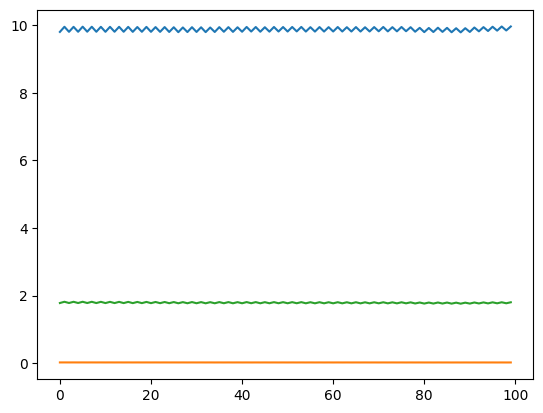

In [253]:
#losses = np.array(losses)
losses_cpu = [(l[0].cpu(), l[1].cpu(), l[2].cpu()) for l in losses]
plt.plot(losses_cpu)

In [516]:
losses[0]

AttributeError: 'tuple' object has no attribute 'cpu'

In [587]:
angle = torch.tensor(0.27)
s = torch.sin(angle)
c = torch.cos(angle)

rot = torch.stack([torch.stack([c, -s]), 
             torch.stack([s, c])])
rot_backward = torch.stack([torch.stack([c, s]), 
             torch.stack([-s, c])])

In [596]:
rot_backward@(rot@torch.tensor(np.ones((100,2)), dtype=torch.float32).T)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [466]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [467]:
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [332]:
star - torch.mean(output, axis=0), torch.mean(output, axis=0)

(tensor([[ 2.0000e+00, -1.8823e-08],
         [ 2.8342e+00,  9.7299e-01],
         [ 1.4484e+00,  1.1273e+00],
         [ 5.6368e-01,  8.6278e-01],
         [ 5.7068e-01,  2.2536e+00],
         [-2.4078e-01,  2.9058e+00],
         [-6.1220e-01,  1.3957e+00],
         [-7.8757e-01,  8.5552e-01],
         [-2.2991e+00,  1.2442e+00],
         [-2.6984e+00,  4.5029e-01],
         [-1.2470e+00, -2.0809e-01],
         [-1.2188e+00, -6.5956e-01],
         [-1.9216e+00, -2.0874e+00],
         [-9.9458e-01, -2.2674e+00],
         [-8.9535e-02, -1.0805e+00],
         [ 4.1126e-01, -1.6240e+00],
         [ 1.6241e+00, -2.4859e+00],
         [ 1.7082e+00, -1.3295e+00],
         [ 9.4905e-01, -3.2581e-01]], device='cuda:0'),
 tensor([6.2742e-09, 1.8823e-08], device='cuda:0'))

In [341]:
target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])
torch.arcsin(torch.sin(torch.diff(torch.concatenate((target_angles, target_angles[:1])))))
target_angles

C:\Users\Admin\AppData\Local\Temp\ipykernel_13376\2346571163.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_angles = torch.atan2(torch.tensor(star)[:,1], torch.tensor(star)[:,0])


tensor([ 0.0000,  0.3307,  0.6614,  0.9921,  1.3228,  1.6535,  1.9842,  2.3149,
         2.6456,  2.9762, -2.9762, -2.6456, -2.3149, -1.9842, -1.6535, -1.3228,
        -0.9921, -0.6614, -0.3307], device='cuda:0')

In [342]:
#output = model(star)
output = star
coordinates = output - torch.mean(output, axis=0)
angles = torch.atan2(coordinates[:,1], coordinates[:,0])
angle_diffs = torch.arcsin(torch.sin(torch.diff(torch.concatenate((angles, angles[:1]))))) - 2*torch.pi/output.shape[0]

print(angles) 
2*torch.pi/output.shape[0], angle_diffs

tensor([-9.4113e-09,  3.3069e-01,  6.6139e-01,  9.9208e-01,  1.3228e+00,
         1.6535e+00,  1.9842e+00,  2.3149e+00,  2.6456e+00,  2.9762e+00,
        -2.9762e+00, -2.6456e+00, -2.3149e+00, -1.9842e+00, -1.6535e+00,
        -1.3228e+00, -9.9208e-01, -6.6139e-01, -3.3069e-01], device='cuda:0')


(0.3306939635357677,
 tensor([ 0.0000e+00,  5.9605e-08, -5.9605e-08,  0.0000e+00,  0.0000e+00,
          1.1921e-07, -1.4901e-07,  0.0000e+00,  2.3842e-07, -4.1723e-07,
          0.0000e+00,  0.0000e+00, -1.4901e-07,  0.0000e+00,  1.1921e-07,
         -5.9605e-08,  0.0000e+00,  0.0000e+00,  5.9605e-08], device='cuda:0'))

In [468]:
%%time

weights = []
gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer, a=1)
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(11.3502, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.5364236831665039, distance_loss: 30.533376693725586
loss tensor(31.0698, device='cuda:0')
volume tensor(11.3504, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.5216335654258728, distance_loss: 30.289257049560547
loss tensor(30.8109, device='cuda:0')
volume tensor(11.3514, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.4958537220954895, distance_loss: 29.872201919555664
loss tensor(30.3681, device='cuda:0')
volume tensor(11.3537, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.4621322453022003, distance_loss: 29.342159271240234
loss tensor(29.8043, device='cuda:0')
volume tensor(11.3581, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.42330312728881836, distance_loss: 28.752479553222656
loss tensor(29.1758, device='cuda:0')
volume tensor(11.3650, device='cuda:0', grad_fn=<SumBackward0>)
angle_loss: 0.381828635931015, distance_loss: 28.145925521850586
loss tensor(28.5278, device='c

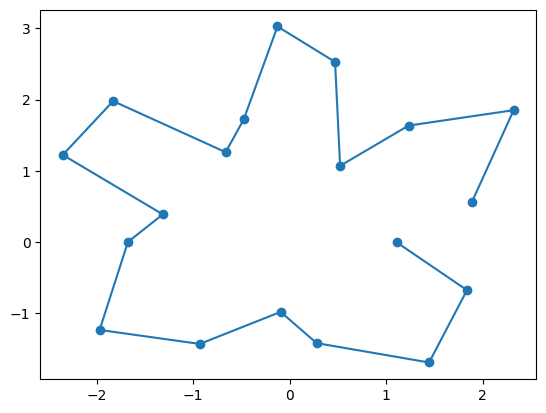

In [469]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [465]:
output

tensor([[ 7.1724e+00, -2.7460e-01],
        [ 6.7222e+00,  9.3666e-01],
        [ 3.0436e+00,  1.3656e+00],
        [ 1.3492e+00,  9.8270e-01],
        [ 1.5267e+00,  2.2021e+00],
        [ 2.4767e-01,  2.0121e+00],
        [-1.0208e-01,  1.3185e+00],
        [-4.2852e-01,  9.6251e-01],
        [-3.3286e+00,  7.5732e-01],
        [-3.2908e+00,  2.4614e-01],
        [-1.6920e+00, -5.5617e-04],
        [-1.6853e+00, -4.3390e-01],
        [-2.0731e+00, -2.7151e+00],
        [-8.8272e-01, -1.0656e+00],
        [ 2.4054e-01, -1.0667e+00],
        [ 6.1591e-01, -1.4368e+00],
        [        nan,         nan],
        [ 9.6876e+00, -2.7285e+00],
        [ 2.1758e+00,  9.3581e-02]], device='cuda:0', grad_fn=<CopySlices>)

In [131]:
isoperimetric_loss(output, target_angles, 1)
torch.atan2(output[:,1], output[:,0]), target_angles

TypeError: isoperimetric_loss() takes 2 positional arguments but 3 were given

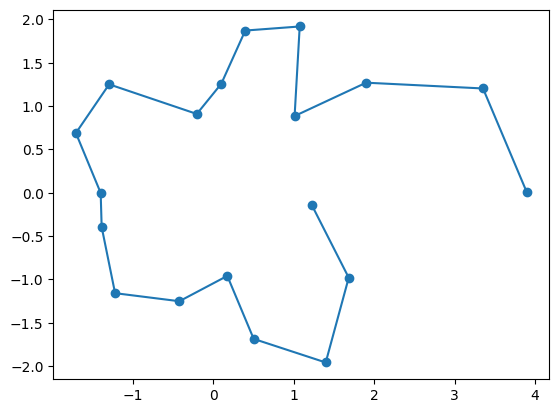

In [457]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

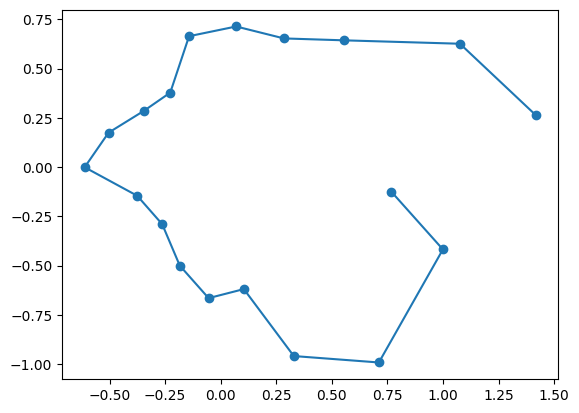

In [164]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [145]:
output

tensor([[ 4.4315e+02,  6.3401e+00],
        [        inf,  4.3322e+02],
        [        inf,  3.0538e+02],
        [ 1.3748e+23,  7.1119e+01],
        [        inf,  5.7210e+03],
        [        inf,  2.6878e+04],
        [        inf,  6.9598e+02],
        [ 9.4807e+21,  6.7417e+01],
        [        inf,  1.1342e+03],
        [ 4.0049e+03,  9.2691e+00],
        [-2.1157e+00, -8.1608e-01],
        [-3.1737e-01, -1.1497e+00],
        [ 4.3813e+01, -3.1019e+00],
        [ 2.5050e+01, -2.4808e+00],
        [ 2.8212e+00, -9.6964e-01],
        [ 4.8190e+00, -1.0512e+00],
        [ 4.0001e+00, -4.9857e-01],
        [ 2.0609e+00,  5.8128e-02],
        [ 1.1910e+00,  1.3368e-01]], device='cuda:0', grad_fn=<CopySlices>)

In [33]:
def compute_area2(points, device=device, requires_grad=False):
    #coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    first, second = normalized[::2],normalized[1::2]
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    n_first, n_second = norms[::2],  norms[1::2]
    print(norms)
    print(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second ))))
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second )))* n_first.flatten() * n_second.flatten())


torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)
volume = compute_area2(output)
print(volume)
volume.backward()


tensor([[1.8089],
        [2.4726],
        [1.8006],
        [1.0997],
        [2.4246],
        [2.8168],
        [1.3378],
        [0.9583],
        [1.9010],
        [2.4857],
        [1.2846],
        [1.3983],
        [2.6418],
        [2.5283],
        [1.1400],
        [1.5361],
        [2.2710],
        [1.4289],
        [0.8848]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


RuntimeError: einsum(): subscript i has size 9 for operand 1 which does not broadcast with previously seen size 10

In [197]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.0121],
         [    nan],
         [-0.0021],
         [    nan],
         [-0.0254],
         [-0.0181],
         [    nan],
         [-0.0040],
         [-0.0611],
         [ 0.0060]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0081,  0.0000, -0.0105,  0.0000, -0.0099, -0.0058,  0.0000, -0.0047,
          -0.0043, -0.0096],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
         [    nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan],
    

In [157]:
get_weights_from_vector(gradients[-1], shapes)

[tensor([[-0.0064],
         [ 0.0005],
         [ 0.0011],
         [ 0.0008],
         [ 0.0128],
         [ 0.0092],
         [ 0.0004],
         [ 0.0020],
         [ 0.0312],
         [-0.0033]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.4663e-03,  0.0000e+00,  5.8179e-03,  0.0000e+00,  5.4892e-03,
           3.2249e-03,  0.0000e+00,  2.6041e-03,  2.3567e-03,  5.2788e-03],
         [-4.5456e-03, -2.1613e-05, -5.9212e-03, -2.8579e-04, -5.5866e-03,
          -3.2821e-03, -1.5870e-04, -2.6504e-03, -2.3985e-03, -5.3725e-03],
         [ 3.7685e-02,  1.7916e-04,  4.9089e-02,  2.3693e-03,  4.6315e-02,
           2.7210e-02,  1.3156e-03,  2.1973e-02,  1.9885e-02,  4.4540e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.8356e-03,  2.

In [187]:
get_weights_from_vector(weights[-2], shapes)

[tensor([[-0.5548],
         [ 0.0650],
         [-0.7227],
         [ 0.8597],
         [-0.6819],
         [-0.4006],
         [ 0.4773],
         [-0.3235],
         [-0.2928],
         [-0.6558]], device='cuda:0'),
 tensor([[ 0.0215,  0.1798, -0.2779, -0.0964,  0.1665, -0.1752,  0.1394,  0.1287,
          -0.0844, -0.0099],
         [ 0.3147,  0.1407, -0.0823, -0.1538,  0.2270,  0.0760,  0.1417,  0.0346,
           0.2881,  0.3080],
         [ 0.0616,  0.0588,  0.0807,  0.1650,  0.1790, -0.1459,  0.1248, -0.0837,
          -0.1537, -0.1046],
         [-0.0424,  0.1356,  0.1147,  0.2495,  0.1182, -0.1875,  0.2965,  0.2099,
          -0.1134, -0.1415],
         [ 0.1103, -0.1041,  0.0741, -0.1205, -0.1739, -0.2008, -0.2801, -0.1787,
           0.1490,  0.0790],
         [-0.0401, -0.0791,  0.2065,  0.2524, -0.0468, -0.1732, -0.0171, -0.0950,
          -0.2605,  0.1998],
         [-0.2735, -0.0380, -0.0034,  0.0204,  0.2392,  0.3008,  0.0373, -0.0212,
          -0.2078, -0.1823],
    

In [188]:
get_weights_from_vector(weights[-1], shapes)

[tensor([[-0.5548],
         [ 0.0650],
         [-0.7227],
         [ 0.8597],
         [-0.6819],
         [-0.4006],
         [ 0.4773],
         [-0.3235],
         [-0.2929],
         [-0.6557]], device='cuda:0'),
 tensor([[ 0.0215,  0.1798, -0.2779, -0.0964,  0.1665, -0.1752,  0.1394,  0.1287,
          -0.0844, -0.0099],
         [ 0.3147,  0.1407, -0.0823, -0.1538,  0.2270,  0.0760,  0.1417,  0.0346,
           0.2880,  0.3079],
         [ 0.0617,  0.0588,  0.0807,  0.1650,  0.1790, -0.1459,  0.1248, -0.0837,
          -0.1537, -0.1046],
         [-0.0425,  0.1356,  0.1145,  0.2495,  0.1180, -0.1876,  0.2965,  0.2098,
          -0.1134, -0.1417],
         [ 0.1103, -0.1041,  0.0741, -0.1205, -0.1739, -0.2008, -0.2801, -0.1787,
           0.1490,  0.0790],
         [-0.0401, -0.0791,  0.2064,  0.2524, -0.0468, -0.1733, -0.0171, -0.0950,
          -0.2605,  0.1998],
         [-0.2735, -0.0380, -0.0034,  0.0204,  0.2392,  0.3008,  0.0374, -0.0212,
          -0.2078, -0.1823],
    

## NaN Gradients können mit größeren Werten behoben werden

In [204]:
torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)*5
volume = compute_area2(output)
print(volume)
volume.backward()

tensor([[9.1208],
        [9.1772],
        [9.2334],
        ...,
        [9.0508],
        [9.0862],
        [9.1208]], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor([0.0049, 0.0050, 0.0051, 0.0051, 0.0052, 0.0052, 0.0053, 0.0053, 0.0053,
        0.0054, 0.0054, 0.0055, 0.0055, 0.0055, 0.0055, 0.0056, 0.0056, 0.0056,
        0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0056, 0.0055, 0.0055,
        0.0055, 0.0055, 0.0054, 0.0054, 0.0053, 0.0053, 0.0052, 0.0052, 0.0051,
        0.0051, 0.0050, 0.0049, 0.0049, 0.0048, 0.0047, 0.0046, 0.0046, 0.0045,
        0.0044, 0.0043, 0.0042, 0.0041, 0.0040, 0.0039, 0.0038, 0.0038, 0.0037,
        0.0036, 0.0034, 0.0033, 0.0033, 0.0032, 0.0031, 0.0030, 0.0029, 0.0028,
        0.0027, 0.0026, 0.0026, 0.0024, 0.0023, 0.0023, 0.0022, 0.0022, 0.0020,
        0.0020, 0.0019, 0.0018, 0.0017, 0.0017, 0.0016, 0.0015, 0.0015, 0.0014,
        0.0013, 0.0013, 0.0012, 0.0011, 0.0011, 0.0010, 0.0010, 0.0010, 0.0009,
        0.0008, 0.0008, 

In [205]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.3011],
         [-0.5046],
         [-0.0535],
         [-0.7921],
         [-0.6319],
         [-0.4504],
         [-0.4679],
         [-0.0987],
         [-1.5220],
         [ 0.1501]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.2013,  0.0000, -0.2622,  0.0000, -0.2474, -0.1454,  0.0000, -0.1174,
          -0.1063, -0.2379],
         [ 0.2212,  0.0228,  0.2882,  0.3018,  0.2719,  0.1598,  0.1676,  0.1290,
           0.1168,  0.2615],
         [-1.8289, -0.1886, -2.3824, -2.4949, -2.2480, -1.3207, -1.3853, -1.0664,
          -0.9654, -2.1616],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.2333, -0.0241, -0.3039, -0.3182, -0.2867, -0.1685, -0.1767, -0.1360,
          -0.1231, -0.2757],
         [ 0.0000,  0.3446,  0.0000,  4.5573,  0.0000,  0.0000,  2.5305,  0.0000,
           0.0000,  0.0000],
    

In [206]:
def compute_area2(points, device=device, requires_grad=False):
    #coordinates = points - torch.mean(points, axis=0)
    normalized = torch.nn.functional.normalize(points, p=2, dim=1, eps=1e-12, out=None)
    first, second = normalized[::2],normalized[1::2]
    norms = torch.norm(points, p=2., dim=1, keepdim=True)
    n_first, n_second = norms[::2],  norms[1::2]
    return torch.sum(torch.sin(torch.acos(torch.einsum ('ij, ij -> i', first, second )))* n_first.flatten() * n_second.flatten())


In [225]:
%%time

# training routine

def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(False)
    model.train()
    #train_loss = 0

    # get volume grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    volume = compute_area2(output)
    volume.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    volume_grad = get_grad_vector(model)
    #volume_grad = torch.nan_to_num(volume_grad)
    #print(volume, volume_grad[:10])
    print('volume', volume)
    volume.detach()
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    loss = isoperimetric_loss(output)
    loss.backward()
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    
    # project on subspace
    grad = get_grad_vector(model)
    #print(grad[:10])
    grad_projected = orthogonal_projection(volume_grad, grad)
    #print(grad_projected[:10])
    shapes = get_shapes(model)
    grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # assign values
    assign_grad_weights(model, grad_weigths)

    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    print('loss', loss)
    return volume_grad, grad 


# weights = []
# gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 5 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(7.7032, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(nan, device='cuda:0')
volume tensor(nan, device='cuda:0', grad_fn=<SumBackward0

KeyboardInterrupt: 

In [222]:
torch.autograd.set_detect_anomaly(False)
optimizer.zero_grad(set_to_none=True)
output = model(star)
volume = compute_area2(output)
print(volume)
volume.backward()

tensor(11.1147, device='cuda:0', grad_fn=<SumBackward0>)


In [221]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 1.2210e-04],
         [        nan],
         [-2.7221e-05],
         [        nan],
         [-3.2589e-04],
         [-2.2376e-04],
         [        nan],
         [-5.3155e-05],
         [-7.4923e-04],
         [ 4.7084e-05]], device='cuda:0'),
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-6.5357e-05,  0.0000e+00, -8.5158e-05,  0.0000e+00, -8.0372e-05,
          -4.7223e-05,  0.0000e+00, -3.8121e-05, -3.4565e-05, -7.7256e-05],
         [        nan,         nan,         nan,         nan,         nan,
                  nan,         nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan,         nan,
                  nan,         nan,         nan,         nan,         nan],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [213]:
optimizer.zero_grad(set_to_none=True)
output = model(star)
loss = isoperimetric_loss(output)
loss.backward()

In [214]:
shapes = get_shapes(model)
get_weights_from_vector(get_grad_vector(model), shapes)

[tensor([[ 0.0082],
         [-0.0254],
         [-0.0015],
         [-0.0397],
         [-0.0183],
         [-0.0129],
         [-0.0235],
         [-0.0029],
         [-0.0435],
         [ 0.0039]], device='cuda:0'),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0053,  0.0000, -0.0069,  0.0000, -0.0065, -0.0038,  0.0000, -0.0031,
          -0.0028, -0.0062],
         [ 0.0063,  0.0011,  0.0082,  0.0152,  0.0078,  0.0046,  0.0084,  0.0037,
           0.0033,  0.0075],
         [-0.0520, -0.0095, -0.0677, -0.1252, -0.0639, -0.0376, -0.0695, -0.0303,
          -0.0275, -0.0615],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000],
         [-0.0066, -0.0012, -0.0086, -0.0159, -0.0081, -0.0048, -0.0088, -0.0038,
          -0.0035, -0.0078],
         [ 0.0000,  0.0173,  0.0000,  0.2288,  0.0000,  0.0000,  0.1271,  0.0000,
           0.0000,  0.0000],
    

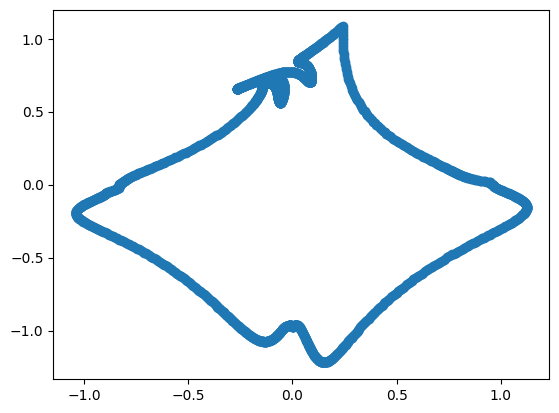

In [224]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

tensor([-0.5552,  0.0640, -0.7228,  ..., -0.2711,  0.1859,  0.0326],
       device='cuda:0')
tensor([-0.5548,  0.0650, -0.7227,  ..., -0.2826,  0.1811,  0.0326],
       device='cuda:0')


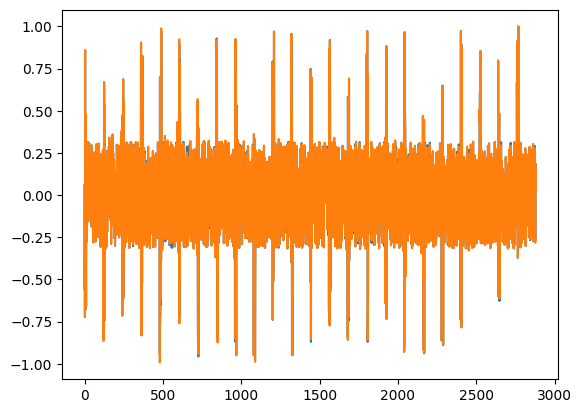

In [208]:
for w in ([weights[0], weights[-1]]):
    plt.plot(w.detach().cpu().numpy())
    print(w)

tensor([ 0.0099,  0.0177, -0.0030,  ...,  0.3459, -0.0628,  0.0000],
       device='cuda:0')
tensor([-0.0061,  0.0006,  0.0011,  ...,  0.0145,  0.0036,  0.0000],
       device='cuda:0')


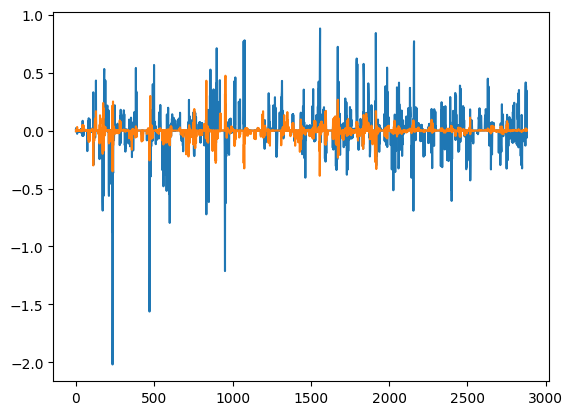

In [209]:
for w in ([gradients[0], gradients[-1]]):
    plt.plot(w.detach().cpu().numpy())
    print(w)

In [341]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [342]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

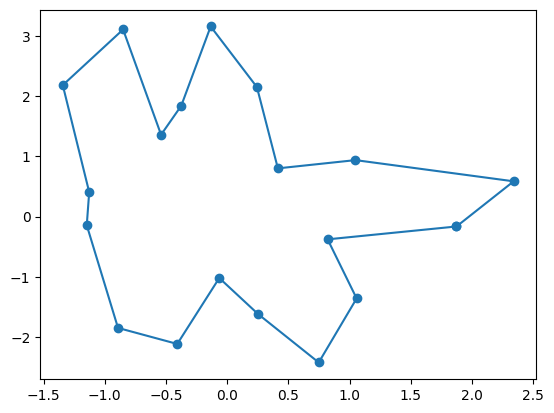

In [343]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

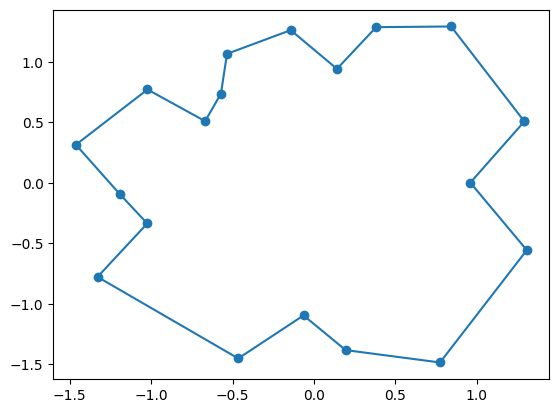

In [346]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

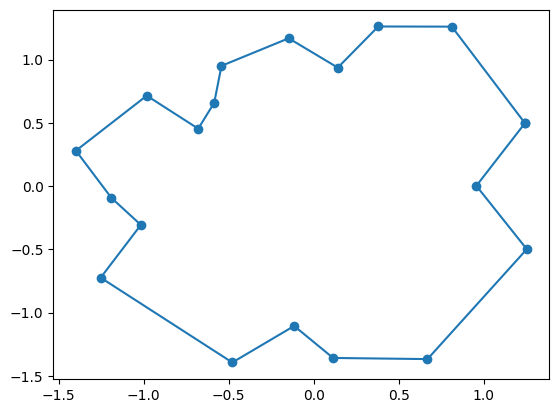

In [348]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

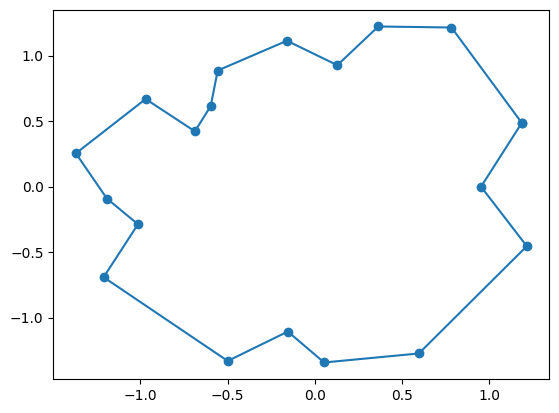

In [350]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

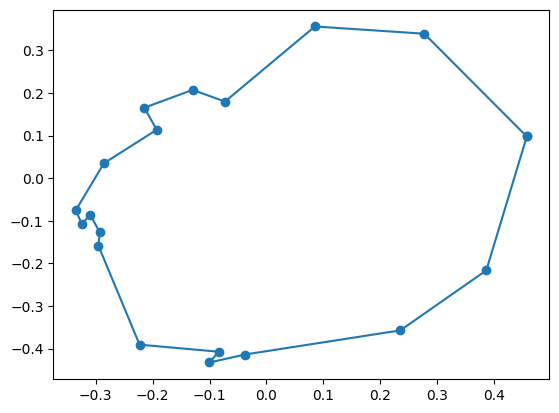

In [353]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

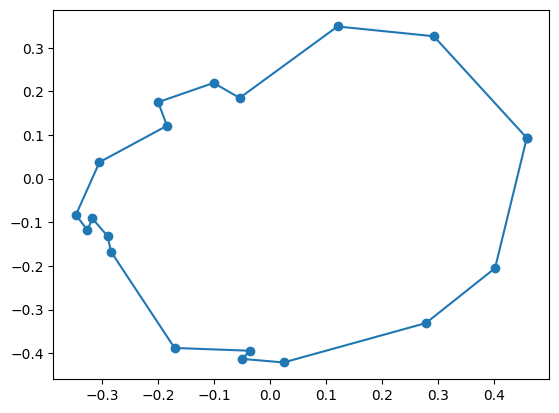

In [355]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [280]:
scheduler.get_last_lr()

[0.0001]

In [356]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [357]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5082, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5077, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5069, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5058, device='cuda:0')
volume tensor(0.5759, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5048, device='cuda:0')
volume tensor(0.5752, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(0.5476, device='cuda:0')
volume tensor(0.4104, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.9727, device='cuda:0')
volume tensor(0.2624, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.2279, device='cuda:0')
volume tensor(0.2826, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.3202, device='cuda:0')
volume tensor(0.5518, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(1.3275, device='cuda:0')


In [363]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [367]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [370]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    v,g = training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

volume tensor(8.5684, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(5.3057, device='cuda:0')
volume tensor(8.6040, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(5.1568, device='cuda:0')
volume tensor(8.6324, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.9998, device='cuda:0')
volume tensor(8.6493, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.8324, device='cuda:0')
volume tensor(8.6530, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.6539, device='cuda:0')
volume tensor(8.6429, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.4645, device='cuda:0')
volume tensor(8.6555, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.2748, device='cuda:0')
volume tensor(8.6435, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(4.1053, device='cuda:0')
volume tensor(8.6905, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(3.9757, device='cuda:0')
volume tensor(8.8127, device='cuda:0', grad_fn=<SumBackward0>)
loss tensor(3.9131, device='cuda:0')


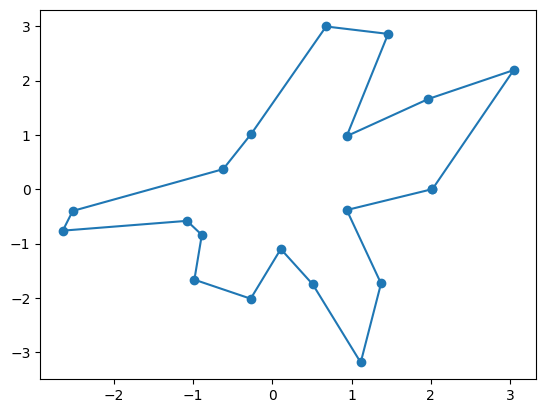

In [364]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

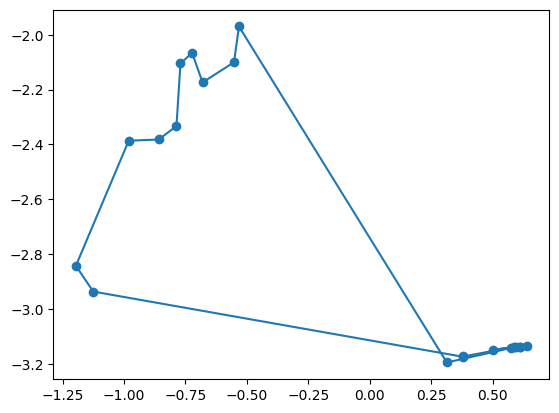

In [369]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [426]:
# training routine

def training_routine_isoperimetric(model, train_data, optimizer):
    torch.autograd.set_detect_anomaly(True)
    model.train()
    #train_loss = 0

    # # get volume grad
    # optimizer.zero_grad(set_to_none=True)
    # output = model(train_data)
    # volume = compute_area2(output)
    # volume.backward()
    # #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)
    # volume_grad = get_grad_vector(model)
    # #print(volume, volume_grad[:10])
    # print('volume', volume)
    # volume.detach()
    
    # get loss grad
    optimizer.zero_grad(set_to_none=True)
    output = model(train_data)
    loss = isoperimetric_loss(output)
    volume = -compute_area2(output)
    weighted_loss = 1*loss + 0.2*volume
    weighted_loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1)

    
    
    # # project on subspace
    # grad = get_grad_vector(model)
    # #print(grad[:10])
    # grad_projected = orthogonal_projection(volume_grad, grad)
    # #print(grad_projected[:10])
    # shapes = get_shapes(model)
    # grad_weigths = get_weights_from_vector(grad_projected, shapes)
    
    # # assign values
    # assign_grad_weights(model, grad_weigths)

    # train step
    #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1, norm_type=1)
    optimizer.step()
    loss = loss.detach()
    volume = volume.detach()
    print('loss', loss)
    print('volume', volume)
    #return volume_grad, grad 

In [406]:
model = NN(num_coupling_layers=12, split_size_x1=1, nn_size=(1, 10)).to(device)


In [424]:
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)

In [425]:
%%time
torch.autograd.set_detect_anomaly(True)
weights = []
gradients = []

for _ in range(100):
    training_routine_isoperimetric(model, star, optimizer)
    if _ % 100 == 0:
        scheduler.step()
    weights.append(get_weights_vector(model))
    gradients.append(get_grad_vector(model))

loss tensor(0.2646, device='cuda:0')
loss tensor(0.1826, device='cuda:0')
loss tensor(1.1199, device='cuda:0')
loss tensor(1.2929, device='cuda:0')
loss tensor(0.5010, device='cuda:0')
loss tensor(1.2779, device='cuda:0')
loss tensor(0.4181, device='cuda:0')
loss tensor(0.3329, device='cuda:0')
loss tensor(0.7849, device='cuda:0')
loss tensor(0.7512, device='cuda:0')
loss tensor(0.4443, device='cuda:0')
loss tensor(0.8054, device='cuda:0')
loss tensor(0.2906, device='cuda:0')
loss tensor(0.3616, device='cuda:0')
loss tensor(1.0387, device='cuda:0')
loss tensor(0.3701, device='cuda:0')
loss tensor(0.4980, device='cuda:0')
loss tensor(0.4888, device='cuda:0')
loss tensor(0.6545, device='cuda:0')
loss tensor(0.5134, device='cuda:0')
loss tensor(0.3647, device='cuda:0')
loss tensor(0.8252, device='cuda:0')
loss tensor(0.6116, device='cuda:0')
loss tensor(0.4952, device='cuda:0')
loss tensor(1.4273, device='cuda:0')
loss tensor(1.1430, device='cuda:0')
loss tensor(0.3733, device='cuda:0')
l

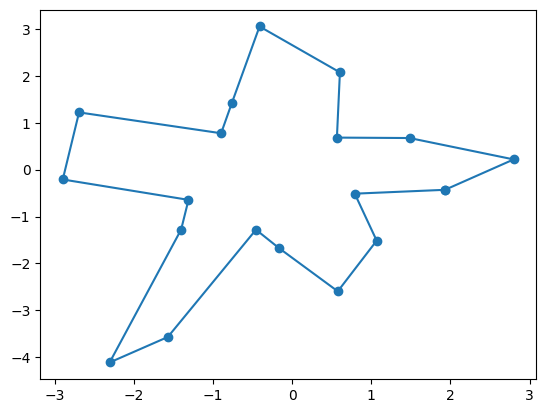

In [408]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

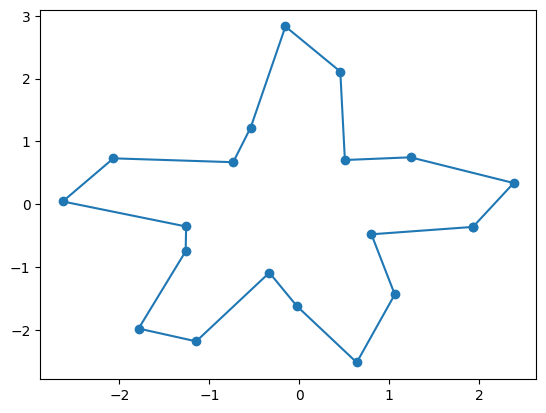

In [410]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

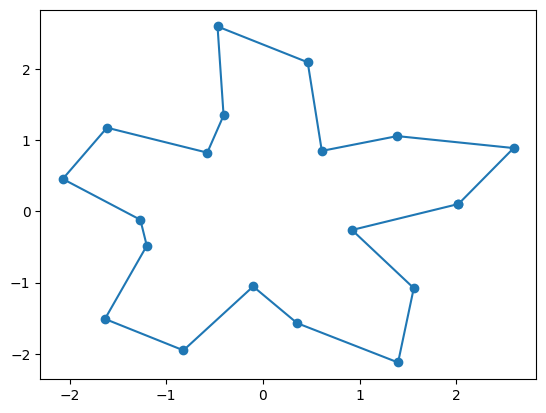

In [413]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

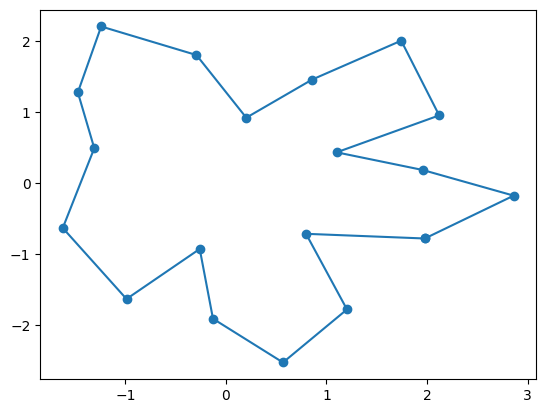

In [416]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

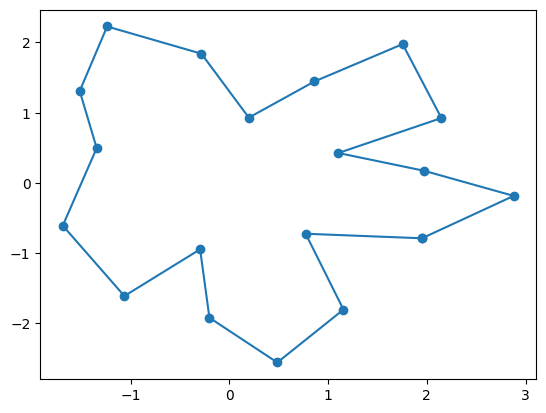

In [419]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

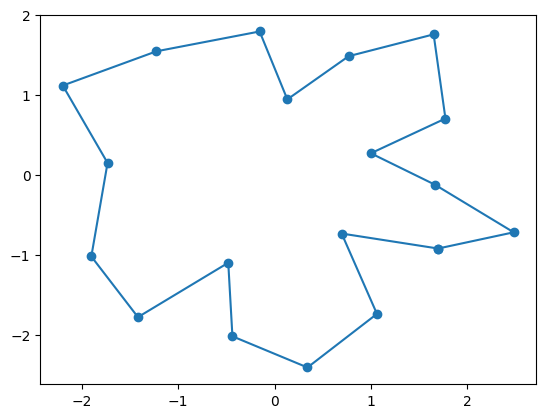

In [422]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

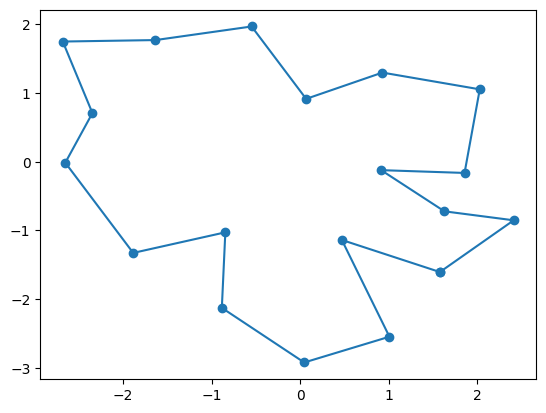

In [427]:
output = model(star)
initial_transformed_star = output.detach().cpu().numpy()
plt.plot(initial_transformed_star[:,0], initial_transformed_star[:,1], '-o')

In [ ]:
# abwechselnd, volume und perimeter trainieren